# Various Tests of the Marginalized Likelihood

In [63]:
from edges_cal.modelling import Model, Polynomial, Fourier
import numpy as np
%matplotlib inline
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from edges_estimate.likelihoods import PartialLinearModel, NoiseWaveLikelihood, DataCalibrationLikelihood
from edges_cal.modelling import NoiseWaves, LinLog, UnitTransform
import numpy as np
from yabf import run_map
from yabf.samplers.emcee import emcee
from edges_cal import CalibrationObservation
from yabf import Component, ParameterVector, ParamVec
import attr
from cached_property import cached_property
from edges_cal import receiver_calibration_func as rcf
from edges_analysis.analysis.calibrate import LabCalibration
from pathlib import Path
from edges_estimate.eor_models import AbsorptionProfile
from edges_cal.simulate import simulate_q_from_calobs, simulate_qant_from_calobs
from scipy import stats
import arviz as av

## Test Raul's Equations

In [10]:
poly1 = Polynomial(parameters=[2, 1, 3, 5, 12]).at(x = np.linspace(0, 100, 500), )

In [11]:
def model(x, a, b):
    return b*np.sin(a*x)

In [99]:
data = poly1() + model(poly1.x, 0.2,2) + np.random.normal(0, scale=poly1()/10, size=len(poly1.x))

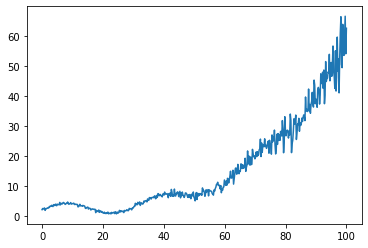

In [100]:
plt.plot(poly1.x, data)

In [20]:
A = poly1.basis

In [105]:
Sig = np.diag(poly1()/10)
SigInv = np.diag(1 / poly1()/10)
C = np.linalg.inv(A.dot(SigInv.dot(A.T)))
SigFG = A.T.dot(C.dot(A))
V = np.linalg.inv(np.linalg.inv(SigFG) - SigInv)
newsig = np.linalg.inv(Sig + V)

In [106]:
def get_curve(args):
    m = model(poly1.x, *args)
    fit = poly1.fit(ydata=data - m)
    d = fit.residual
    return m + fit.evaluate()

def log_likelihood(args):
    d = get_curve(args)
    d = data - d
    return 0.5 * d.dot(newsig.dot(d))

In [107]:
log_likelihood((0.2, 2))

344.72280658512034

In [108]:
res = minimize(log_likelihood, x0=[0.2, 2])

In [109]:
res

      fun: 342.9035846988345
 hess_inv: array([[ 5.82152404e-07, -1.50552766e-06],
       [-1.50552766e-06,  2.71780105e-03]])
      jac: array([-3.81469727e-06, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 5
     njev: 10
   status: 0
  success: True
        x: array([0.19884729, 1.94360821])

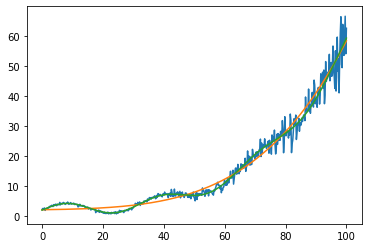

In [111]:
plt.plot(poly1.x, data)
plt.plot(poly1.x, poly1())
plt.plot(poly1.x, get_curve(res.x))

In [112]:
newsig

array([[ 4.66402695, -0.32637864, -0.31695036, ..., -0.00853187,
        -0.00877019, -0.00900995],
       [-0.32823789,  4.67431535, -0.30984119, ..., -0.00800893,
        -0.00823288, -0.00845819],
       [-0.32063201, -0.31166437,  4.68361124, ..., -0.00750016,
        -0.0077101 , -0.00792134],
       ...,
       [-0.00857864, -0.00823151, -0.00789447, ...,  0.16820637,
        -0.00531476, -0.00537577],
       [-0.00872534, -0.00836908, -0.00802317, ..., -0.0053185 ,
         0.16689587, -0.00544296],
       [-0.00883486, -0.00846992, -0.00811563, ..., -0.00538327,
        -0.00544673,  0.16559239]])

## Test CompositeModel

In [20]:
from edges_cal.modelling import CompositeModel

### With No extra basis

In [37]:
comp_mdl = CompositeModel(
    models={
        'one': Polynomial(parameters=[0,2,3]),
        'two': Fourier(parameters=[5,2,-1])
    }
).at(x=np.linspace(50, 100, 100))

In [38]:
data = comp_mdl()
data += np.random.normal(loc=0, scale=0.001, size=data.shape)

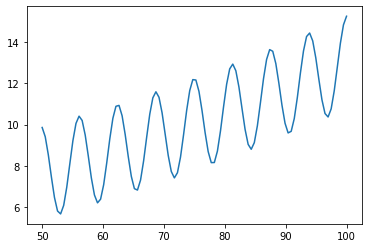

In [39]:
plt.plot(comp_mdl.x, data)

In [40]:
fit = comp_mdl.fit(ydata=data)

In [41]:
fit.model_parameters

array([ 2.49861881,  2.00570144,  2.99711202,  2.49861881,  2.0001951 ,
       -1.00000395])

This result makes sense, because the first and fourth parameters are completely degenerate, and they add up to ~5.

### With Extra Basis

In [46]:
comp_mdl = CompositeModel(
    models={
        'one': Polynomial(parameters=[0,2,3]),
        'two': Fourier(parameters=[5,2,-1])
    },
    extra_basis= {
        'one': lambda x: np.exp(-(x - 75)**2 / 15**2),
        'two': lambda x: ((x - 75)/15)**4
    }
).at(x=np.linspace(50, 100, 100))

In [47]:
data = comp_mdl()
data += np.random.normal(loc=0, scale=0.001, size=data.shape)

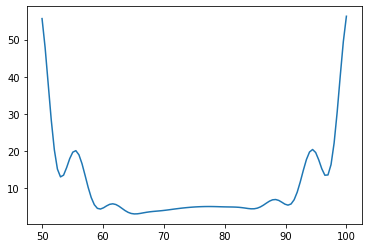

In [48]:
plt.plot(comp_mdl.x, data)

In [49]:
fit = comp_mdl.fit(ydata=data)

In [50]:
fit.model_parameters

array([ 0.00921444,  1.98301479,  3.00772971,  4.99996969,  2.00005895,
       -1.00008788])

This also seems to work well enough.

## Test Noise Wave Model

### With Simplistic S11

In [4]:
freq = np.linspace(50, 100, 100)
gamma_src = {f'derp{i}': 0.6 * (2 + np.sin(i*freq)) for i in range(4)}
gamma_lna = 0.6 * np.ones(len(freq)) + 0.2*np.sin(freq)*1j

model = NoiseWaves(
    freq=freq, 
    gamma_src=gamma_src, 
    gamma_rec=gamma_lna
)


In [5]:
data = model(parameters=[1,2,3,4,5,6, 1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5])

In [6]:
fit = model.linear_model.fit(ydata=data)

In [7]:
fit.model_parameters

array([1., 2., 3., 4., 5., 6., 1., 2., 3., 4., 5., 6., 1., 2., 3., 4., 5.,
       6., 1., 2., 3., 4., 5.])

### With Realistic S11

In [64]:
calobs = CalibrationObservation(
    "/data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2015_09_02_040_to_200MHz/", 
    f_low=50.0,
    f_high=100.0,
    run_num={"receiver_reading": 6},
    repeat_num=1,
    cterms=6,
    wterms=5,
    load_kwargs= {"t_load": 300, "t_load_ns": 350},
    load_spectra = {
        "hot_load": {"ignore_times_percent": 10},
        "ambient": {"ignore_times_percent": 7},
        "open": {"ignore_times_percent": 7},
        "short": {"ignore_times_percent": 7},
    },
    load_s11s = {"lna":{'n_terms': 11, 'model_type': 'polynomial'}}
)

In [9]:
nw_model = NoiseWaves(
    freq=calobs.freq.freq, 
    gamma_src=calobs.s11_correction_models,
    gamma_rec = calobs.lna.s11_model(calobs.freq.freq),
    parameters=[6,5,4,3,2,1, 6,5,4,3,2,1, 6,5,4,3,2,1, 5,4,3,2,1]
)

In [10]:
data = nw_model()
#data += np.random.normal(loc=0, scale=0.01, size=data.shape)

In [11]:
fit = nw_model.linear_model.fit(ydata=data)

In [12]:
fit.model_parameters

array([6., 5., 4., 3., 2., 1., 6., 5., 4., 3., 2., 1., 6., 5., 4., 3., 2.,
       1., 5., 4., 3., 2., 1.])

### With Realistic Noise Waves

In [5]:
nw_model = NoiseWaves.from_calobs(calobs)

In [6]:
data = nw_model()

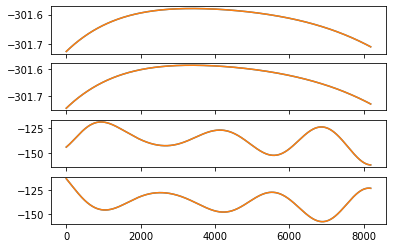

In [7]:
fig, ax = plt.subplots(4, 1, sharex=True)
for i, src in enumerate(nw_model.src_names):
    ax[i].plot(data[i*calobs.freq.n:(i+1)*calobs.freq.n])
    ax[i].plot(nw_model.get_full_model(src))

### With A Smidge of Noise

In [8]:
nw_model = NoiseWaves.from_calobs(calobs)

In [9]:
data = nw_model()
data += np.random.normal(loc=0, scale=np.abs(data/100000))

In [10]:
best_params = nw_model.linear_model.fit(ydata=data, weights=1/np.abs(data)).model_parameters

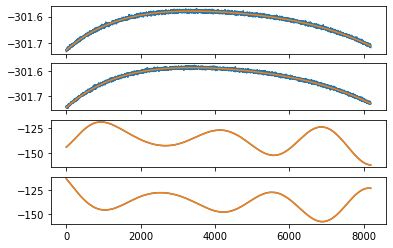

In [11]:
fig, ax = plt.subplots(4, 1, sharex=True)
for i, src in enumerate(nw_model.src_names):
    ax[i].plot(data[i*calobs.freq.n:(i+1)*calobs.freq.n])
    ax[i].plot(nw_model.get_full_model(src))

### Test against iterative fit

In [65]:
nw_model = NoiseWaves.from_calobs(calobs)

#### Show that the NoiseWave model is equal to calobs

In [66]:
def get_data(name,calobs):
    """Get the 'data' vector for a load, i.e. Tns*Q - c T_ant/h"""
    load = calobs._loads[name]
    tns = calobs.C1() * load.spectrum.t_load_ns
    q = load.spectrum.averaged_Q
    
    c = calobs.get_K()[name][0]
    return tns*q - c * load.temp_ave

def get_data_model(name, calobs):
    """Get the 'model' vector for a load, i.e. KT + (C1 - TL)"""
    K = calobs.get_K()[name]
    return K[1]*calobs.Tunc() + K[2]*calobs.Tcos() + K[3]*calobs.Tsin() + calobs.C2() - calobs.open.spectrum.t_load

def get_data_model_mine(name, calobs, nw_model):
    c2 = (-calobs.C2_poly.coefficients[::-1]).tolist()
    c2[0] += calobs.open.spectrum.t_load

    params = (
        calobs.Tunc_poly.coefficients[::-1].tolist() +
        calobs.Tcos_poly.coefficients[::-1].tolist() +
        calobs.Tsin_poly.coefficients[::-1].tolist() +
        c2
    )
    return nw_model.get_full_model(src=name, parameters=params)

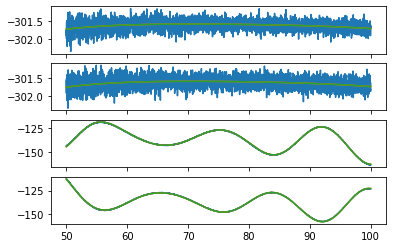

In [14]:
fig, ax = plt.subplots(4, 1, sharex=True)
for i, (name, load) in enumerate(calobs._loads.items()):
    ax[i].plot(calobs.freq.freq, get_data(name, calobs))
    ax[i].plot(calobs.freq.freq, get_data_model(name, calobs))
    ax[i].plot(calobs.freq.freq, get_data_model_mine(name, calobs, nw_model))
    

#### Verify fit for specified Tns

##### With exact simulated data

In [15]:
sim_data = nw_model.get_data_from_calobs(calobs=calobs, sim=True)

In [16]:
fitted_nw = nw_model.get_fitted(sim_data, weights=1.0)

In [17]:
fitted_nw.parameters - nw_model.parameters

array([ 1.42108547e-13,  3.35287353e-13, -7.98694444e-13, -2.08943973e-13,
        1.21880284e-12, -1.38555833e-13, -3.86357613e-14,  8.52651283e-14,
       -5.50670620e-14, -1.76747506e-13,  7.81597009e-14, -4.97379915e-14,
       -3.28626015e-14,  5.35127498e-14,  2.49800181e-14,  0.00000000e+00,
       -4.21954138e-14,  5.86301840e-14, -9.97535388e-14,  1.32602263e-14,
        1.70939651e-14])

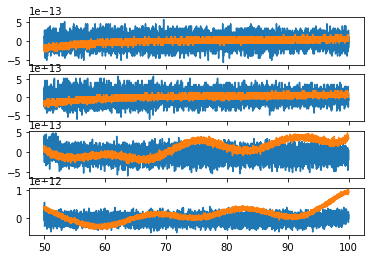

In [18]:
fig, ax = plt.subplots(4, 1, sharex=True)
for i, (name, load) in enumerate(calobs._loads.items()):
    model = get_data_model(name, calobs)
    ax[i].plot(calobs.freq.freq, sim_data[i*calobs.freq.n:(i+1)*calobs.freq.n] - model)
    ax[i].plot(calobs.freq.freq, fitted_nw.get_full_model(name) - model)
    #ax[i].plot(calobs.freq.freq, get_data(name, calobs)-model)

##### With actual Real Data

In [19]:
actual_data = nw_model.get_data_from_calobs(calobs=calobs)

In [20]:
fitted_nw = nw_model.get_fitted(actual_data, weights=1.0)

In [21]:
fitted_nw.parameters - nw_model.parameters

array([-5.07094012e-04, -1.41377911e-04,  1.10141491e-03,  2.59751088e-04,
       -1.01402328e-03, -1.39838995e-04, -2.48620295e-03,  3.19701015e-03,
        7.42182094e-03, -6.91570977e-03, -1.32453324e-04, -4.03537568e-03,
        3.56803377e-03,  9.82417825e-03, -4.58045535e-03,  4.15460077e-04,
        4.36376275e-01, -7.20743152e-03, -2.03611095e+00,  8.88591961e-03,
        1.83205590e+00])

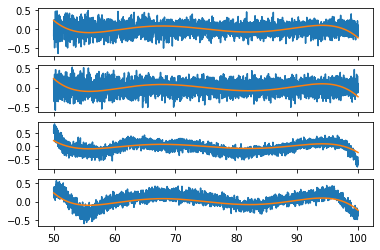

In [22]:
fig, ax = plt.subplots(4, 1, sharex=True)
for i, (name, load) in enumerate(calobs._loads.items()):
    model = get_data_model(name, calobs)
    ax[i].plot(calobs.freq.freq, get_data(name, calobs) - model)
    ax[i].plot(calobs.freq.freq, fitted_nw.get_full_model(name) - model)
    

#### Fit for Tns as well

Here we try fitting with four different noise models: with/without Tns multiplying the noise, and with/without the measured variance multiplying the noise. THe only one that doesn't seem to work is when you don't multiply by the variance (but do multiply by Tns).

$$Q T_{\rm NS} - k_0 T_{\rm src} = \mathbf{K} \mathbf{T}_{\rm NW} + \mathcal{N}(0, \sigma^2_{Q}T^2_{\rm NS})$$

Procedure:

* Get measurements for $Q$, $T_{\rm src}$, $k_0$, $\mathbf{K}$ and $\sigma^2_Q$
* Choose values for $T_{\rm NS}$
* Calculate the LHS and the variance
* Get the MLE for $\mathbf{\hat{T}}_{\rm NW}$ conditioned on the chosen $T_{\rm NS}$
* Calculate the $\chi^2$ likelihood where the residuals are just the LHS - RHS and the variance is $\sigma_Q^2 T_{\rm NS}^2$ (i.e. need to use the determinant because covariance depends on parameters)
* Update $T_{\rm NS}$ and repeat...



In [23]:
nwl = NoiseWaveLikelihood.from_calobs(calobs)

In [24]:
res = run_map(nwl.partial_linear_model, bounds=False)

In [25]:
res

      fun: 21531.369581798757
 hess_inv: array([[ 0.00238056, -0.00030921, -0.00529344,  0.00040264,  0.00048678,
         0.00071964],
       [-0.00030921,  0.0069996 ,  0.00401855, -0.002355  , -0.00850582,
        -0.00475676],
       [-0.00529344,  0.00401855,  0.02568768, -0.00572572, -0.01928794,
        -0.00082365],
       [ 0.00040264, -0.002355  , -0.00572572,  0.01181605,  0.00870453,
        -0.01248199],
       [ 0.00048678, -0.00850582, -0.01928794,  0.00870453,  0.04785128,
        -0.00649055],
       [ 0.00071964, -0.00475676, -0.00082365, -0.01248199, -0.00649055,
         0.03163149]])
      jac: array([-0.10107422,  0.08081055, -0.046875  ,  0.0546875 ,  0.20898438,
       -0.05517578])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 523
      nit: 18
     njev: 73
   status: 2
  success: False
        x: array([1491.41325078, -203.48712876,   59.91575634,   15.1763919 ,
         11.53126281,  -35.37029275])

In [26]:
fit, data, var = nwl.partial_linear_model.reduce_model(params=res.x)

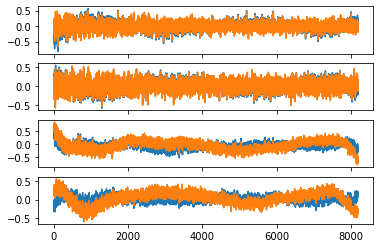

In [27]:
fig, ax = plt.subplots(4, 1, sharex=True)
for i, load in enumerate(calobs._loads):
    ax[i].plot(fit.residual[i*calobs.freq.n: (i+1)*calobs.freq.n])
    ax[i].plot(get_data(load, calobs) - get_data_model(load, calobs) )

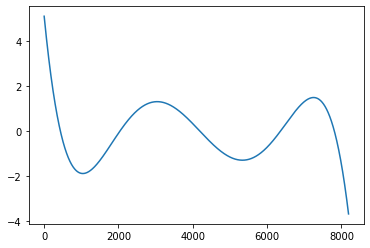

In [28]:
nwl = NoiseWaveLikelihood.from_calobs(calobs, sig_by_tns=False)
res = run_map(nwl.partial_linear_model, bounds=False)
plt.plot(nwl.t_ns_model.model(parameters=res.x) - calobs.C1() * calobs.open.spectrum.t_load_ns)

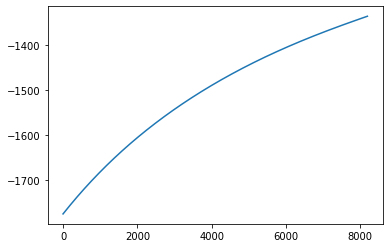

In [29]:
nwl = NoiseWaveLikelihood.from_calobs(calobs, sig_by_sigq=False)
res = run_map(nwl.partial_linear_model, bounds=False)
plt.plot(nwl.t_ns_model.model(parameters=res.x) - calobs.C1() * calobs.open.spectrum.t_load_ns)

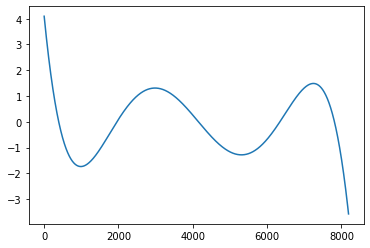

In [30]:
nwl = NoiseWaveLikelihood.from_calobs(calobs, sig_by_sigq=False, sig_by_tns=False)
res = run_map(nwl.partial_linear_model, bounds=False)
plt.plot(nwl.t_ns_model.model(parameters=res.x) - calobs.C1() * calobs.open.spectrum.t_load_ns)

#### Compare Keith's versus Mine versus Raul's Fit

In [4]:
nwl_mine = NoiseWaveLikelihood.from_calobs(calobs, version='mine')

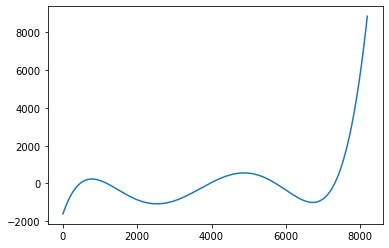

In [39]:
res = run_map(nwl_mine.partial_linear_model, bounds=False)
plt.plot(nwl_mine.t_ns_model.model(parameters=res.x) - calobs.C1() * calobs.open.spectrum.t_load_ns)

OK, so as expected, mine doesn't work :-)

In [4]:
nwl_raul = NoiseWaveLikelihood.from_calobs(calobs, version='raul')

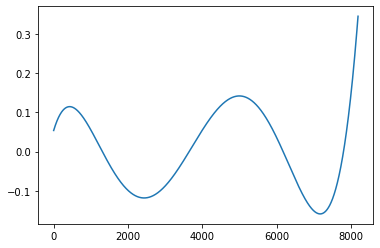

In [5]:
res = run_map(nwl_raul.partial_linear_model, bounds=False)
plt.plot(nwl_raul.t_ns_model.model(parameters=res.x) - calobs.C1() * calobs.open.spectrum.t_load_ns)

Hmmmm.... not bad, but not exactly like Keith's. It might just be precision loss.

In [6]:
nwl_keith = NoiseWaveLikelihood.from_calobs(calobs, version='keith')

In [7]:
res2 = res.x.copy()
res2[0] += 100

In [9]:
nwl_raul.partial_linear_model(params=res.x)[0], nwl_keith.partial_linear_model(params=res.x)[0]

(-21041.618734891803, -20855.16741519535)

In [8]:
nwl_raul.partial_linear_model(params=res.x)[0] - nwl_raul.partial_linear_model(params=res2)[0], nwl_keith.partial_linear_model(params=res.x)[0] - nwl_keith.partial_linear_model(params=res2)[0]

(4955782.368198046, 4920549.980761597)

In [14]:
fit, data, var = nwl_keith.partial_linear_model.reduce_model(params=res.x)

### Test Increase of Evidence

In [47]:
from getdist import loadMCSamples
from getdist import plots
import simulation_exploration_utils as simutils

In [48]:
default = loadMCSamples('./sim_cal_c6_w5_smooth32')

./sim_cal_c6_w5_smooth32.txt
Removed no burn in


In [49]:
g = plots.get_subplot_plotter()
g.triangle_plot(
    default, filled=True, params=[f't_lns_{i}' for i in range(6)], markers=simutils.fid_calobs.t_load_ns * simutils.fid_calobs.C1_poly.coeffs[::-1]
)
g.export("default_sim_cal_corner.png")

In [45]:
g.triangle_plot?

Signature:
g.triangle_plot(
    roots,
    params=None,
    legend_labels=None,
    plot_3d_with_param=None,
    filled=False,
    shaded=False,
    contour_args=None,
    contour_colors=None,
    contour_ls=None,
    contour_lws=None,
    line_args=None,
    label_order=None,
    legend_ncol=None,
    legend_loc=None,
    title_limit=None,
    upper_roots=None,
    upper_kwargs=mappingproxy({}),
    upper_label_right=False,
    diag1d_kwargs=mappingproxy({}),
    markers=None,
    marker_args=mappingproxy({}),
    param_limits=mappingproxy({}),
    **kwargs,
)
Docstring:
Make a trianglular array of 1D and 2D plots.

A triangle plot is an array of subplots with 1D plots along the diagonal, and 2D plots in the lower corner.
The upper triangle can also be used by setting upper_roots.

:param roots: root name or :class:`~.mcsamples.MCSamples` instance (or list of any of either of these) for
              the samples to plot
:param params: list of parameters to plot (default: all, can also

## Test Field Data Model

### With Simulated Data

In [33]:
calfile = calobs.write("test-calfile.h5")

In [67]:
labcal = LabCalibration(
    calobs=calobs, s11_files=sorted(Path('/data5/edges/data/S11_antenna/low_band/20160830_a/s11').glob('*.s1p'))
)

In [68]:
eor = AbsorptionProfile(
    freqs=calobs.freq.freq, 
    params={
        "A": {'fiducial': 0.5, 'min': 0, 'max': 1.5, "ref": stats.norm(0.5, scale=0.01) },
        "w": {'fiducial': 15, 'min': 5, 'max': 25, "ref": stats.norm(15, scale=0.1)},
        "tau": {'fiducial': 5, 'min': 0, 'max': 20, "ref": stats.norm(5, scale=0.1)},
        "nu0": {'fiducial': 78, 'min': 60, 'max': 90, 'ref': stats.norm(78, scale=0.1)},
    }
)

In [69]:
fg = LinLog(n_terms=5, parameters=[2000, 10, -10, 5, -5])
fgx= fg.at(x=calobs.freq.freq)

In [70]:
spec = fgx() + eor(params=[0.5, 15, 5, 78])['eor_spectrum']

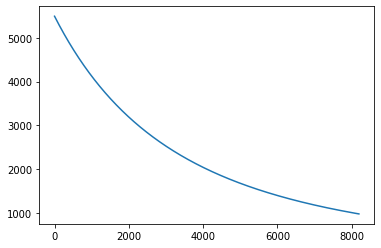

In [16]:
plt.plot(spec)

In [71]:
q = simulate_qant_from_calobs(
    calobs, ant_s11=labcal.antenna_s11, ant_temp=spec, 
    scale_model=Polynomial(parameters=[4.5, -0.5, 0.2, -0.05, 0.02, -0.01], transform=UnitTransform())
)

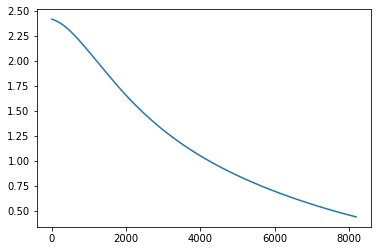

In [18]:
plt.plot(q)

In [72]:
t_ns_params = ParamVec(
    't_lns', length=nw_model.c_terms, 
    min=[1400.0, -300, -100, -50, -10, -10], 
    max=[1700.0, 300, 100, 50, 10, 10],
    ref=[
        stats.norm(1575., scale=3), 
        stats.norm(-175., scale=1.0), 
        stats.norm(70.0, scale=1.0), 
        stats.norm(-17.5, scale=1.0),
        stats.norm(7.0, scale=0.5),
        stats.norm(-3.5, scale=0.1)
    ],
    fiducial=[1575, -175, 70.0, -17.5, 7.0, -3.5]
)

In [73]:
data_lk_sim = DataCalibrationLikelihood.from_labcal(
    labcal, 
    q_ant=q, 
    qvar_ant=np.zeros_like(calobs.freq.freq), 
    fg_model=fg, 
    eor_components=(eor,),
    sim=True,
    scale_model=Polynomial(parameters=[4.5, -0.5, 0.2, -0.05, 0.02, -0.01], transform=UnitTransform()),
    t_ns_params=t_ns_params,
    cal_noise=0.0
)

In [74]:
data_lk_real = DataCalibrationLikelihood.from_labcal(
    labcal, 
    q_ant=q, 
    qvar_ant=1e-8 * np.ones(calobs.freq.n),
    fg_model=fg, 
    eor_components=(eor,),
    sim=False,
    t_ns_params=t_ns_params
)

Text(0.5, 0.98, 'Noiseless Simulated Calibration Data')

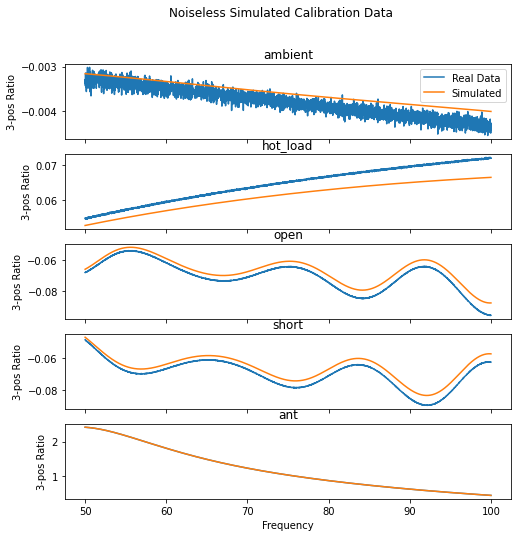

In [14]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8,8))
for i, name in enumerate(data_lk_sim.data['q']):
    ax[i].plot(calobs.freq.freq, data_lk_real.data['q'][name], label="Real Data")
    ax[i].plot(calobs.freq.freq, data_lk_sim.data['q'][name], label="Simulated")
    ax[i].set_title(name)
    ax[i].set_ylabel("3-pos Ratio")
    
ax[0].legend()
ax[-1].set_xlabel("Frequency")
fig.suptitle("Noiseless Simulated Calibration Data")

In [75]:
true_lns = data_lk_sim.t_ns_model.model
lns_params = true_lns.model.parameters.tolist()

#### At particular TNS and EOR

In [16]:
fit, data, var = data_lk_sim.partial_linear_model.reduce_model(
    params=lns_params+[0.5, 15, 5, 78]
)

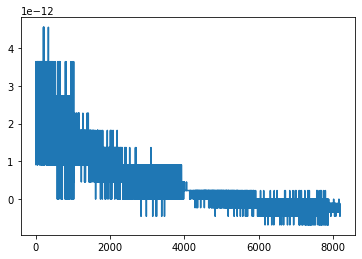

In [17]:
plt.plot(fit.fit.model.fg(calobs.freq.freq) - fgx())

In [18]:
fit.model_parameters - data_lk_sim.partial_linear_model.linear_model.model.parameters

array([ 2.21689334e-12, -3.81916720e-14, -1.65789604e-12, -1.24078525e-12,
       -1.94066985e-13,  4.68958206e-13, -5.64881475e-13,  3.24185123e-13,
        1.21680443e-12, -8.21565038e-13, -4.15667500e-13, -8.13571432e-13,
        1.10933485e-12,  3.36397576e-13, -1.80522264e-12,  1.36424205e-12,
        1.49464469e-12, -4.39804443e-13, -1.10066123e-12,  8.71809569e-13,
        1.03378417e-12,  2.27373675e-13, -2.22755148e-12, -2.17426077e-12,
       -1.90070182e-13,  6.42685904e-12])

#### Fit TNS and EOR

In [19]:
data_lk_sim.partial_linear_model()

(-20557.963182102376, [])

In [20]:
res_data = run_map(data_lk_sim.partial_linear_model)

In [76]:
def getstuff(self,params):
    # Ensure we don't use flagged channels
    
    fit, data, var = self.reduce_model(params=params)

    if not hasattr(var, '__len__'):
        var = var * np.ones(len(data))

    logdetSig = np.sum(var) if self.variance_func is not None else 0

    try:
        logdetCinv = self.logdetCinv
    except AttributeError:
        logdetCinv = np.log(np.linalg.det((fit.model.basis / var).dot(fit.model.basis.T)))

    lnl = - 0.5 * (logdetSig + logdetCinv + np.sum(fit.residual**2/var))
    
    return lnl, fit, data, var, logdetSig, logdetCinv, np.sum(fit.residual**2/var)

def compare_params(lk, params):
    lnl, fit, data, var, sig, c, chi2 = getstuff(lk.partial_linear_model, [p.fiducial for p in lk.partial_linear_model.child_active_params])
    lnl_, fit_, data_, var_, sig_, c_, chi2_ = getstuff(lk.partial_linear_model, params)
    
    print("Fit - Correct lnl (bigger is better): ", lnl_ - lnl)
    print("Fit - Correct |Sigma| (bigger is worse): ", sig_ - sig)
    print("Fit - Correct |C| (bigger is worse): ", c_ - c)
    print("Fit - Correct chi^2 (bigger is worse): ", chi2_ - chi2)

In [22]:
compare_params(data_lk_sim, res_data.x)

Fit - Correct lnl (bigger is better):  nan
Fit - Correct |Sigma| (bigger is worse):  0.0
Fit - Correct |C| (bigger is worse):  nan
Fit - Correct chi^2 (bigger is worse):  nan


/tmp/ipykernel_14601/3579911428.py:14: RuntimeWarning: divide by zero encountered in true_divide
  logdetCinv = np.log(np.linalg.det((fit.model.basis / var).dot(fit.model.basis.T)))
/tmp/ipykernel_14601/3579911428.py:14: RuntimeWarning: invalid value encountered in true_divide
  logdetCinv = np.log(np.linalg.det((fit.model.basis / var).dot(fit.model.basis.T)))
/home/smurray/miniconda3/envs/edges/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/tmp/ipykernel_14601/3579911428.py:16: RuntimeWarning: divide by zero encountered in true_divide
  lnl = - 0.5 * (logdetSig + logdetCinv + np.sum(fit.residual**2/var))
/tmp/ipykernel_14601/3579911428.py:16: RuntimeWarning: invalid value encountered in true_divide
  lnl = - 0.5 * (logdetSig + logdetCinv + np.sum(fit.residual**2/var))
/tmp/ipykernel_14601/3579911428.py:18: RuntimeWarning: divide by zero encountered in true_divide
  return lnl, f

In [77]:
def view_results(lk, res_data, sim_tns=True, calobs=calobs, smooth=1):
    eorspec = lk.partial_linear_model.get_ctx(params=res_data.x)

    fig, ax = plt.subplots(2, 2, figsize=(15, 7), sharex=True)

    if sim_tns:
        sim_tns = true_lns()
    else:
        sim_tns = calobs.C1()*calobs.t_load_ns
        
    nu = calobs.freq.freq
    ax[0, 0].plot(nu, eorspec['tns'], label='Estimated')
    ax[0, 0].plot(nu, sim_tns, label='input')
    ax[1, 0].plot(nu, eorspec['tns'] - sim_tns, color='k', label=r"$\Delta T_{\rm NS}$")
    if len(lk.nwfg_model.field_freq) == len(nu):
        ax[1, 0].plot(nu,(eorspec['tns'] - sim_tns)*lk.data['q']['ant'], color='r', label=r"$\Delta T_{\rm NS} Q_{\rm ant}$")
    ax[0, 0].set_title(r"$T_{\rm NS}$")
    ax[0, 0].set_ylabel("Temperature [K]")
    
    ax[0, 1].plot(lk.nwfg_model.field_freq, eorspec['eor_spectrum'])
    ax[0, 1].plot(nu,eor()['eor_spectrum'])
    ax[0, 1].set_title(r"$T_{21}$")
    ax[1, 1].plot(nu[::smooth], eorspec['eor_spectrum'] - eor()['eor_spectrum'][::smooth], color='k')
    ax[1, 0].set_ylabel("Difference [K]")
    
    ax[1, 0].set_xlabel("Frequency")
    ax[1, 1].set_xlabel("Frequency")
    
    ax[0, 0].legend()
    ax[1, 0].legend()
    
    return fig

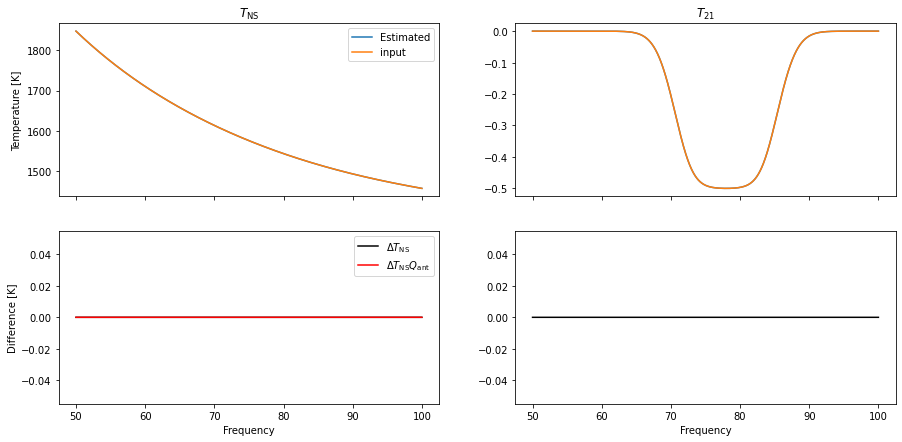

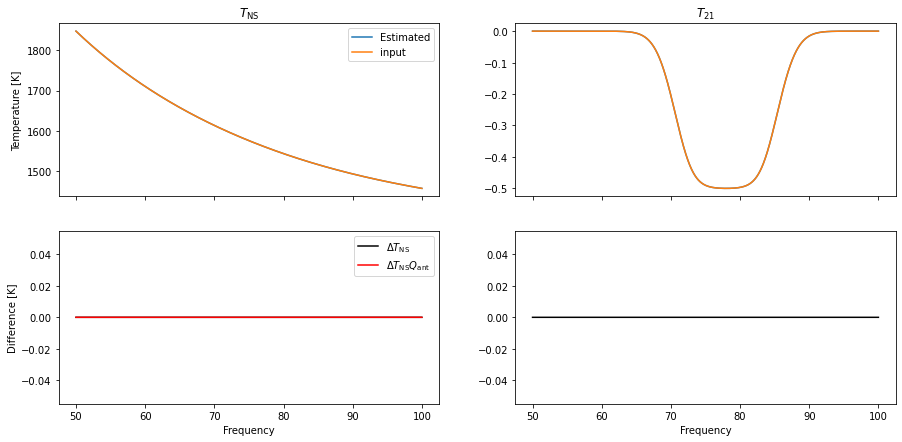

In [24]:
view_results(data_lk_sim, res_data)

### With Noisy Simulated Data

In [31]:
varq = 1e-10 * np.ones_like(calobs.freq.freq)

In [32]:
qant_noise = q + np.random.normal(scale=np.sqrt(varq))

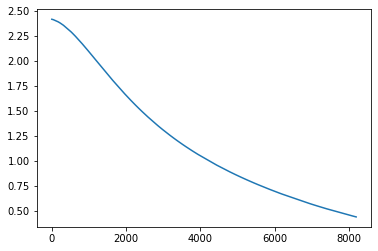

In [33]:
plt.plot(qant_noise)

In [34]:
data_lk_sim_noise = DataCalibrationLikelihood.from_labcal(
    labcal, 
    q_ant=qant_noise, 
    qvar_ant=varq, 
    fg_model=fg, 
    eor_components=(eor,),
    sim=True,
    scale_model=Polynomial(parameters=[4.5, -0.5, 0.2, -0.05, 0.02, -0.01], transform=UnitTransform()),
    cal_noise=1e-10,
    t_ns_params=t_ns_params
)

Text(0.5, 0.98, 'Noiseless Simulated Calibration Data')

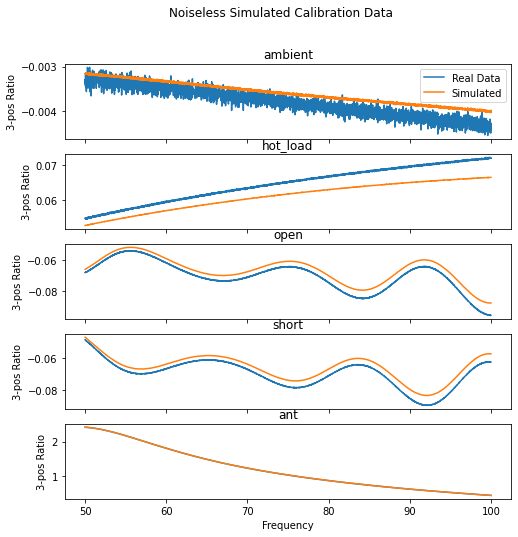

In [35]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8,8))
for i, name in enumerate(data_lk_sim.data['q']):
    ax[i].plot(calobs.freq.freq, data_lk_real.data['q'][name], label="Real Data")
    ax[i].plot(calobs.freq.freq, data_lk_sim_noise.data['q'][name], label="Simulated")
    ax[i].set_title(name)
    ax[i].set_ylabel("3-pos Ratio")
    
ax[0].legend()
ax[-1].set_xlabel("Frequency")
fig.suptitle("Noiseless Simulated Calibration Data")

In [36]:
res_data = run_map(data_lk_sim_noise.partial_linear_model)

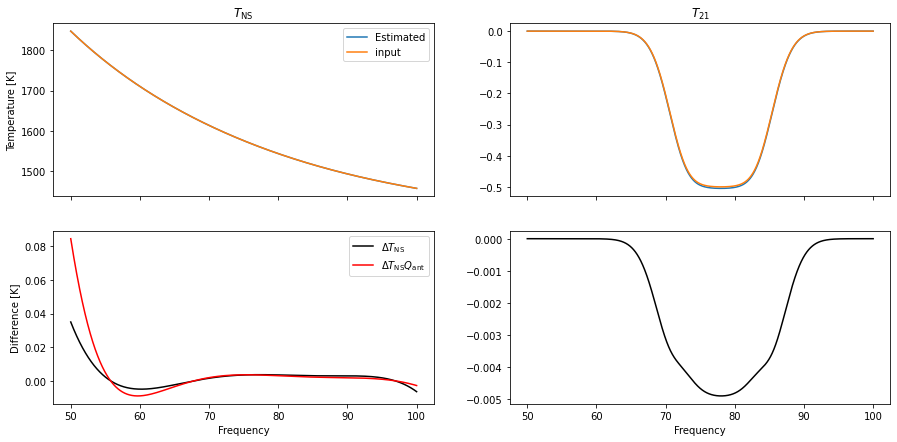

In [37]:
view_results(data_lk_sim_noise, res_data)

In [38]:
compare_params(data_lk_sim_noise, res_data.x)

Fit - Correct lnl (bigger is better):  4.293404106199887
Fit - Correct |Sigma| (bigger is worse):  3.071505621221604e-05
Fit - Correct |C| (bigger is worse):  -0.00011885163547731281
Fit - Correct chi^2 (bigger is worse):  -8.586720075822086


In [39]:
res_data

      fun: 20927.769355847136
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.00009095, -0.70758632, -0.35688595, -0.96042633, -1.58761396,
       -1.17543096,  6.4999767 ,  0.97679723,  0.63701009,  1.51885711])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 583
      nit: 41
     njev: 53
   status: 0
  success: True
        x: array([ 1.57500347e+03, -1.74996086e+02,  6.99744452e+01, -1.74745345e+01,
        7.03634495e+00, -3.55010928e+00,  5.04910742e-01,  1.50218689e+01,
        4.96409100e+00,  7.80006638e+01])

### With More Realistic Noise

In [40]:
varq = 1e-10 * np.ones_like(calobs.freq.freq)
qant_noise = q + np.random.normal(scale=np.sqrt(varq))

In [41]:
data_lk_sim_realnoise = DataCalibrationLikelihood.from_labcal(
    labcal, 
    q_ant=qant_noise, 
    qvar_ant=varq, 
    fg_model=fg, 
    eor_components=(eor,),
    sim=True,
    scale_model=Polynomial(parameters=[4.5, -0.5, 0.2, -0.05, 0.02, -0.01], transform=UnitTransform()),
    t_ns_params=t_ns_params
)

Text(0.5, 0.98, 'Noiseless Simulated Calibration Data')

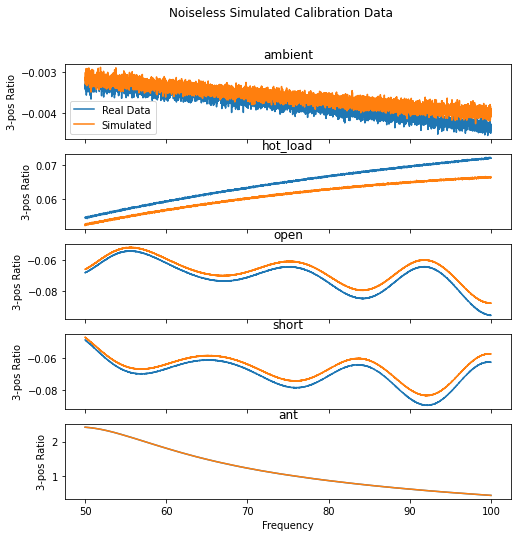

In [42]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8,8))
for i, name in enumerate(data_lk_sim.data['q']):
    ax[i].plot(calobs.freq.freq, data_lk_real.data['q'][name], label="Real Data")
    ax[i].plot(calobs.freq.freq, data_lk_sim_realnoise.data['q'][name], label="Simulated")
    ax[i].set_title(name)
    ax[i].set_ylabel("3-pos Ratio")
    
ax[0].legend()
ax[-1].set_xlabel("Frequency")
fig.suptitle("Noiseless Simulated Calibration Data")

In [ ]:
res_data = run_map(data_lk_sim_realnoise.partial_linear_model)

In [44]:
compare_params(data_lk_sim_realnoise, res_data.x)

Fit - Correct lnl (bigger is better):  9.053864956418693
Fit - Correct |Sigma| (bigger is worse):  0.014480569927115994
Fit - Correct |C| (bigger is worse):  -0.0008004469545426218
Fit - Correct chi^2 (bigger is worse):  -18.121410035812005


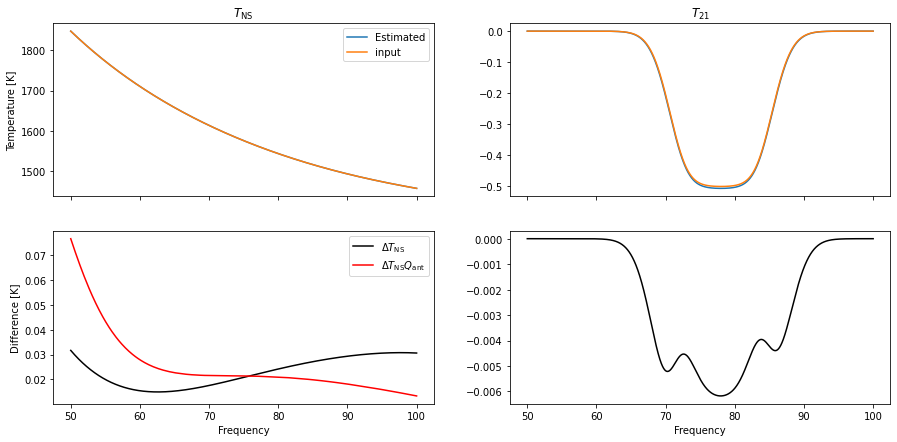

In [59]:
view_results(data_lk_sim_realnoise, res_data)

### With Data-Driven Noise

One thing that could be idealized so far is that the noise we add is actually Gaussian and actually has the variance that we say it does. We should check if this is true, and what happens if it's not quite true.

What we can do is get the residuals of each input and use that directly as noise, on top of the simulated Q.

In [11]:
def get_resids(src, n_terms=5):
    fit = Polynomial(
        n_terms=n_terms, transform=UnitTransform()
    ).fit(
        xdata=calobs.freq.freq, 
        ydata=calobs._loads[src].spectrum.averaged_Q
    )
    return fit.residual

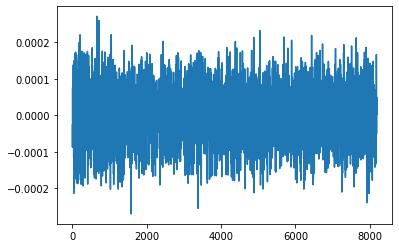

In [12]:
plt.plot(get_resids('open', n_terms=30))

In [13]:
def plot_hist(src, n_terms=5):
    var = calobs._loads[src].spectrum.variance_Q / calobs._loads[src].spectrum.n_integrations
    std = np.mean(np.sqrt(var))
    resid = get_resids(src, n_terms)
    
    x = np.linspace(-5*std, 5*std, 500)
    plt.hist(resid, density=True,bins=100);
    plt.plot(x, stats.norm(scale=std).pdf(x))
    plt.title(src)

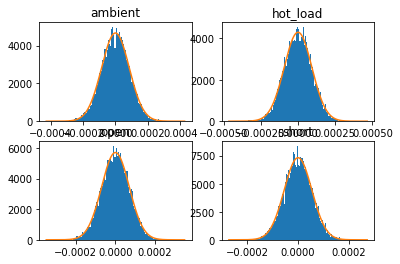

In [14]:
fig, ax = plt.subplots(2,2)

plt.sca(ax[0,0])
plot_hist('ambient', n_terms=5)

plt.sca(ax[0,1])
plot_hist('hot_load', n_terms=5)

plt.sca(ax[1,0])
plot_hist('open', n_terms=25)

plt.sca(ax[1,1])
plot_hist('short', n_terms=25)


They all look nice and Gaussian. This tells us that we need around 25 terms to get the resids for the open and short. 

In [22]:
varq = 1e-10 * np.ones_like(calobs.freq.freq)
qant_noise = q + np.random.normal(scale=np.sqrt(varq))

In [24]:
data_lk_sim_datanoise = DataCalibrationLikelihood.from_labcal(
    labcal, 
    q_ant=qant_noise, 
    qvar_ant=varq, 
    fg_model=fg, 
    eor_components=(eor,),
    sim=True,
    scale_model=Polynomial(parameters=[4.5, -0.5, 0.2, -0.05, 0.02, -0.01], transform=UnitTransform()),
    t_ns_params=t_ns_params,
    cal_noise={
        'ambient': get_resids("ambient", n_terms=5),
        'hot_load': get_resids("hot_load", n_terms=5),
        'open': get_resids("open", n_terms=25),
        'short': get_resids("short", n_terms=25),
    }
)

Text(0.5, 0.98, 'Noiseless Simulated Calibration Data')

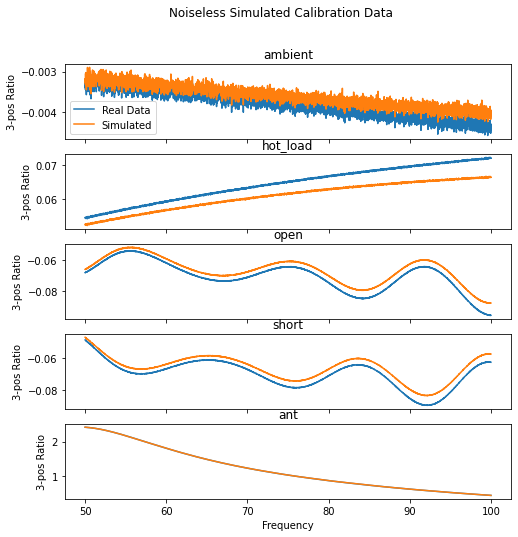

In [25]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8,8))
for i, name in enumerate(data_lk_sim.data['q']):
    ax[i].plot(calobs.freq.freq, data_lk_real.data['q'][name], label="Real Data")
    ax[i].plot(calobs.freq.freq, data_lk_sim_datanoise.data['q'][name], label="Simulated")
    ax[i].set_title(name)
    ax[i].set_ylabel("3-pos Ratio")
    
ax[0].legend()
ax[-1].set_xlabel("Frequency")
fig.suptitle("Noiseless Simulated Calibration Data")

In [26]:
res_data = run_map(data_lk_sim_datanoise.partial_linear_model)

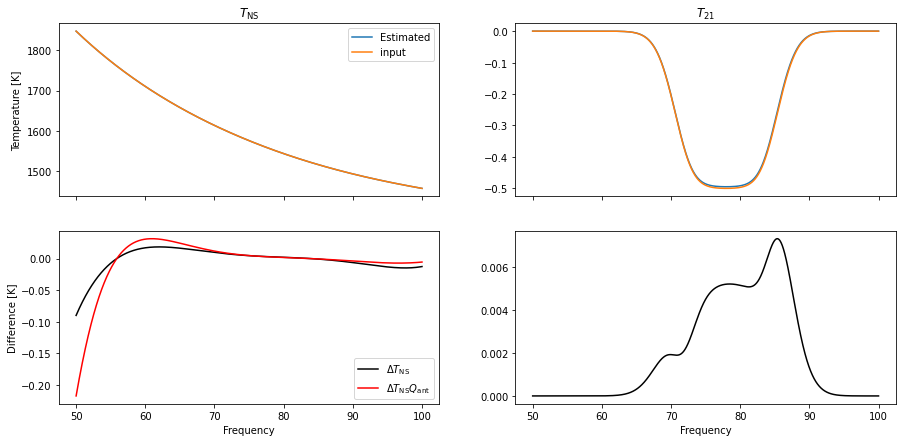

In [32]:
view_results(data_lk_sim_datanoise, res_data)

This is still pretty darn good, so it's probably not this that's screwing things up.

### With Real Calibration Data

In [60]:
varq = 1e-8 * np.ones_like(calobs.freq.freq)

In [61]:
q = simulate_qant_from_calobs(
    calobs, ant_s11=labcal.antenna_s11, ant_temp=spec, 
)

In [62]:
qant_noise = q + np.random.normal(scale=np.sqrt(varq))

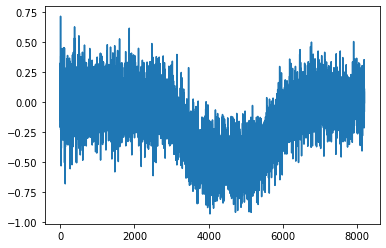

In [63]:
plt.plot(labcal.calibrate_q(qant_noise) - fgx())

In [64]:
est_tns = calobs.C1_poly.coeffs[::-1]*calobs.t_load_ns
t_ns_params_real = ParamVec(
    't_lns', length=nw_model.c_terms, 
    min=[1400.0, -300, -100, -50, -50, -50], 
    max=[1700.0, 300, 100, 50, 50, 50],
    ref=[
        stats.norm(est_tns[0], scale=3), 
        stats.norm(est_tns[1], scale=1.0), 
        stats.norm(est_tns[2], scale=1.0), 
        stats.norm(est_tns[3], scale=1.0),
        stats.norm(est_tns[4], scale=0.5),
        stats.norm(est_tns[5], scale=0.1)
    ],
    fiducial=est_tns
)

In [65]:
data_lk_real = DataCalibrationLikelihood.from_labcal(
    labcal, 
    q_ant=qant_noise, 
    qvar_ant=varq, 
    fg_model=fg, 
    eor_components=(eor,),
    sim=False,
    t_ns_params=t_ns_params_real,
)

In [66]:
res_data = run_map(data_lk_real.partial_linear_model)

In [67]:
res_data

      fun: 28024.509598920973
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.76989541e-01,  4.95856118e-01,  4.31828049e-01,  3.51064957e-01,
       -4.72937206e-03,  2.55386091e-01, -7.81365093e+02, -2.10638956e-01,
        2.36104826e-01, -2.28465213e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 704
      nit: 32
     njev: 64
   status: 0
  success: True
        x: array([1491.86715015, -198.88234109,   55.22015039,   -5.05039569,
         17.12875165,  -17.88938215,    1.49999998,   15.97258166,
          2.41293441,   79.52287114])

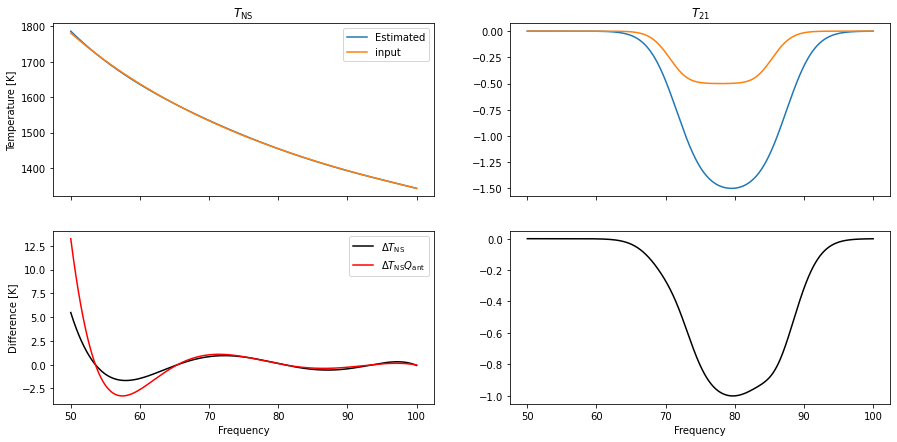

In [69]:
view_results(data_lk_sim_realnoise, res_data, sim_tns=False)

In [78]:
_, fit, _, var = getstuff(data_lk_real.partial_linear_model, res_data.x)[:4]
_, fit2, _, var2 = getstuff(data_lk_real.partial_linear_model, [p.fiducial for p in data_lk_real.partial_linear_model.child_active_params])[:4]
_, fit3, _, var3 = getstuff(data_lk_real.partial_linear_model, res_data.x[:-4].tolist() + [0.5, 15, 5, 78])[:4]


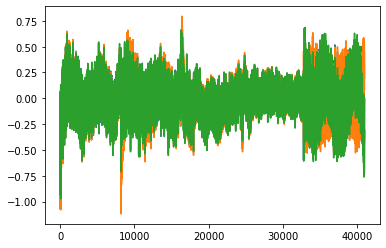

In [80]:
plt.plot(fit.residual)#/var)
plt.plot(fit2.residual)#/var2)
plt.plot(fit3.residual)#/var3)

#plt.plot(3*np.sqrt(var), 'k--')
#plt.plot(3*np.sqrt(var2), 'r--')

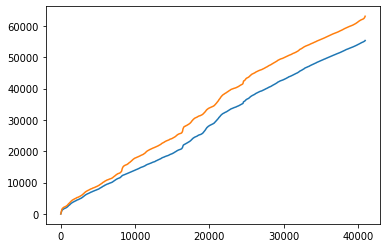

In [76]:
plt.plot(np.cumsum(fit.residual**2/var))
plt.plot(np.cumsum(fit2.residual**2/var2))

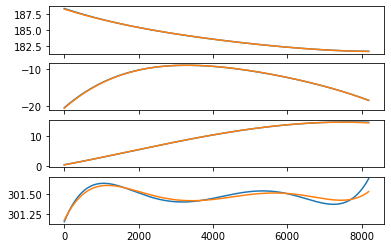

In [79]:
fig, ax = plt.subplots(4, 1, sharex=True)

ax[0].plot(fit.fit.model.tunc(x=calobs.freq.freq))
ax[0].plot(fit2.fit.model.tunc(x=calobs.freq.freq))
ax[1].plot(fit.fit.model.tcos(x=calobs.freq.freq))
ax[1].plot(fit2.fit.model.tcos(x=calobs.freq.freq))
ax[2].plot(fit.fit.model.tsin(x=calobs.freq.freq))
ax[2].plot(fit2.fit.model.tsin(x=calobs.freq.freq))
ax[3].plot(fit.fit.model.tload(x=calobs.freq.freq))
ax[3].plot(fit2.fit.model.tload(x=calobs.freq.freq))


In [87]:
compare_params(data_lk_real, res_data.x)

Fit - Correct lnl (bigger is better):  3502.5220932898847
Fit - Correct |Sigma| (bigger is worse):  -0.011803213273196889
Fit - Correct |C| (bigger is worse):  -0.003100307005865943
Fit - Correct chi^2 (bigger is worse):  -7005.029283059492


In [77]:
compare_params(data_lk_real, res_data.x[:-4].tolist() + [0.5, 15,5, 78])

Fit - Correct lnl (bigger is better):  -151.9557332151926
Fit - Correct |Sigma| (bigger is worse):  0.06471452748144202
Fit - Correct |C| (bigger is worse):  -0.009755025444746934
Fit - Correct chi^2 (bigger is worse):  303.85650692834315


#### With emcee

In [28]:
sampler = emcee(data_lk_real.partial_linear_model, sampler_kwargs={'nwalkers': 50, 'threads': 12})

In [29]:
sampler.sample(nsteps=2000, progress='notebook')

{'sigma': 0.013} -23546.09302950924
{'sigma': 0.013} -3933.155490870704
{'sigma': 0.013} -3791.515184012358
{'sigma': 0.013} -5070.868622615701
{'sigma': 0.013} -2729.677880998177
{'sigma': 0.013} -1703.2554822116508
{'sigma': 0.013} -26168.50419970404
{'sigma': 0.013} -1780.4178784164833
{'sigma': 0.013} -987.5770310685621
{'sigma': 0.013} -13056.506953169883
{'sigma': 0.013} -2117.408003121731
{'sigma': 0.013} -13703.808898417396
{'sigma': 0.013} -218.911066310131
{'sigma': 0.013} -1087.769208117621
{'sigma': 0.013} -1502.6873530835728
{'sigma': 0.013} -28411.30415480223
{'sigma': 0.013} -25505.453053558536
{'sigma': 0.013} -914.4626702211681
{'sigma': 0.013} -49105.36383023509
{'sigma': 0.013} -15967.842144124617
{'sigma': 0.013} -10001.013383628451
{'sigma': 0.013} -7369.61046941689
{'sigma': 0.013} -2844.4258272385923
{'sigma': 0.013} -4023.7626110986457
{'sigma': 0.013} -2820.472957262071
{'sigma': 0.013} -15750.948191786418
{'sigma': 0.013} -3979.0627728761174
{'sigma': 0.013} -

  0%|          | 0/2000 [00:00<?, ?it/s]

{'sigma': 0.013} -16772.30390590045
{'sigma': 0.013} -31472.5655256107
{'sigma': 0.013} -6024.235519609647
{'sigma': 0.013} -1445.1078862904105
{'sigma': 0.013} -121586.1464150236
{'sigma': 0.013} -4368.118665529939
{'sigma': 0.013} -8600.172104872181
{'sigma': 0.013} -250.48232191673014
{'sigma': 0.013} -5073.247928772529
{'sigma': 0.013} -12451.104371902009
{'sigma': 0.013} -8307.433861390688
{'sigma': 0.013} -807.0724966268754
{'sigma': 0.013} -188.59427810064517
{'sigma': 0.013} -700.6134299171972
{'sigma': 0.013} -19336.02852427942
{'sigma': 0.013} -4186.55138384091
{'sigma': 0.013} -914.1853018449037
{'sigma': 0.013} -3028.4135333739105
{'sigma': 0.013} -20416.916663825454
{'sigma': 0.013} -164051.2332663237
{'sigma': 0.013} -18891.041030808003
{'sigma': 0.013} -2316.4300327874953
{'sigma': 0.013} -1335.356895600271
{'sigma': 0.013} -14219.380618708383
{'sigma': 0.013} -5350.55195876502
{'sigma': 0.013} -13443.951307492505
{'sigma': 0.013} -4308.508982949832
{'sigma': 0.013} -105

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'sigma': 0.013} 1981.5174852536293
{'sigma': 0.013} 1968.9970499457559
{'sigma': 0.013} 1971.0660898069618
{'sigma': 0.013} 1975.481999597163
{'sigma': 0.013} 1959.3489726632833
{'sigma': 0.013} 1974.5190168719273
{'sigma': 0.013} 1977.865970326122
{'sigma': 0.013} 1967.391202191764
{'sigma': 0.013} 1968.6309697862016
{'sigma': 0.013} 1977.9316257427563
{'sigma': 0.013} 1979.860712806927
{'sigma': 0.013} 1972.0767168405
{'sigma': 0.013} 1980.3682414058712
{'sigma': 0.013} 1978.7172319053207
{'sigma': 0.013} 1976.15126502543
{'sigma': 0.013} 1955.2790288972901
{'sigma': 0.013} 1980.7404240341275
{'sigma': 0.013} 1980.245590170729
{'sigma': 0.013} 1941.9048703523586
{'sigma': 0.013} 1973.7550095430342
{'sigma': 0.013} 1959.2072534199106
{'sigma': 0.013} 1975.0210250380333
{'sigma': 0.013} 1976.1741035121959
{'sigma': 0.013} 1980.4133226287668
{'sigma': 0.013} 1972.7324431721936
{'sigma': 0.013} 1979.366393948032
{'sigma': 0.013} 1979.8830845843768
{'sigma': 0.013} 1968.7145969984704
{'s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [45]:
emcee_data = av.from_emcee(sampler._sampler, var_names = [p.name for p in sampler.likelihood.child_active_params])

In [46]:
emcee_data_burnin = emcee_data.sel(draw=slice(300, None))

In [47]:
av.rcParams['plot.max_subplots'] = 60

/home/smurray/miniconda3/envs/edges/lib/python3.9/site-packages/arviz/plots/pairplot.py:223: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


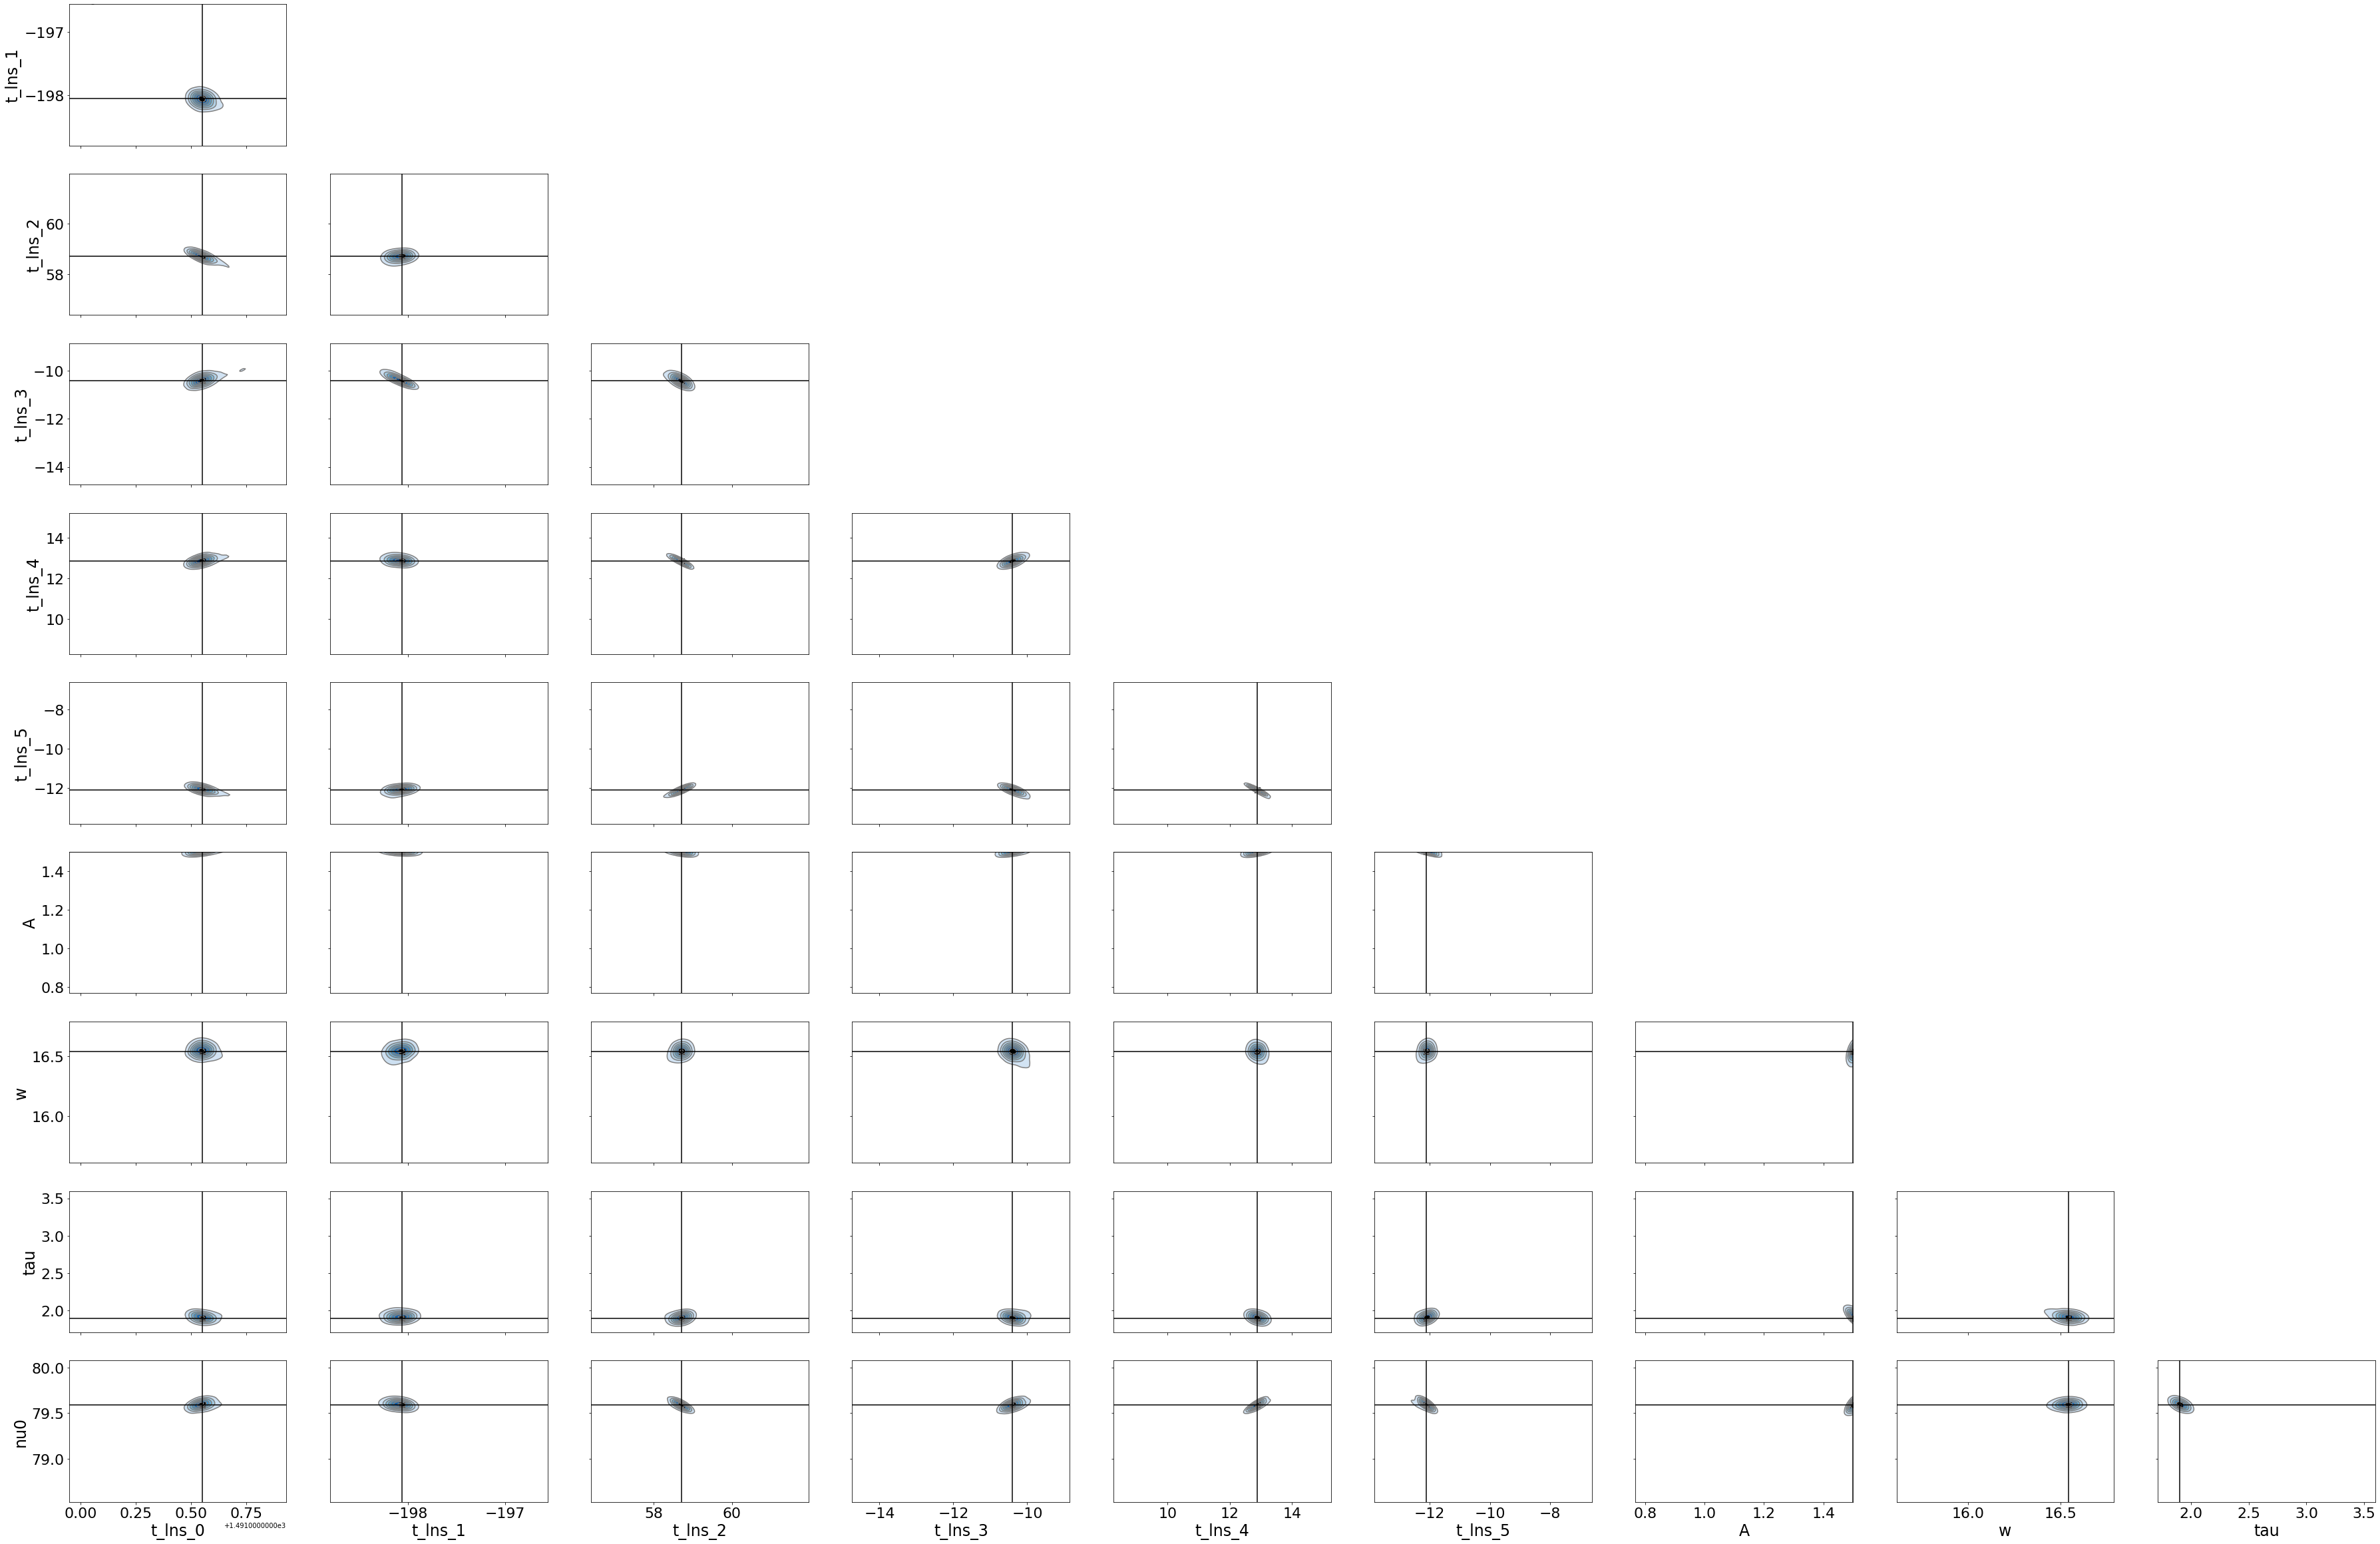

In [48]:
av.plot_pair(
    emcee_data_burnin,
#    var_names=["theta", "mu", "tau"],
    kind="kde",
    #coords=coords,
    divergences=True,
    textsize=22,
    kde_kwargs={
    #    "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    reference_values={p.name: p.fiducial for p in sampler.likelihood.child_active_params},
    point_estimate='mode'
);

In [84]:
mn = [float(emcee_data.mean().to_dict()['posterior'][p.name]) for p in sampler.likelihood.child_active_params]

In [85]:
mn

[1502.4642580312657,
 -198.97014687682287,
 47.159521224776256,
 -10.236588623959452,
 8.0744404531658,
 -5.564438005826616,
 0.5148475228536331,
 14.67995850177725,
 6.668010312542268,
 79.71735735748612]

In [86]:
data_lk_real.partial_linear_model(params=mn)

(-401796.96934683935, [])

In [87]:
data_lk_real.partial_linear_model(params=[1575. , -175. ,   70. ,  -17.5,    7. ,   -3.5]+[0.5, 15, 5, 78])

(-9195377.144662436, [])

In [89]:
getstuff(data_lk_real.partial_linear_model, params=mn)

(116214712.90329924,
 ModelFit(model=FixedLinearModel(model=CompositeModel(models={'tunc': Polynomial(parameters=array([183.50813865,  -2.91178749,   0.35039468,  -0.54104395,
          1.38645542]), n_terms=5, transform=UnitTransform(), offset=0.0), 'tcos': Polynomial(parameters=array([-9.284575  , -3.59996278, -7.48599293,  4.51238344, -2.66215983]), n_terms=5, transform=UnitTransform(), offset=0.0), 'tsin': Polynomial(parameters=array([10.51139528,  8.75132418, -3.54070413, -1.64678437,  0.56743693]), n_terms=5, transform=UnitTransform(), offset=0.0), 'tload': Polynomial(parameters=array([ 3.01481877e+02, -4.11812043e-02, -1.23188374e-02,  3.14127638e-02,
         3.36372200e-02, -1.67668157e-02]), n_terms=6, transform=UnitTransform(), offset=0.0), 'fg': LinLog(parameters=array([2000,   10,  -10,    5,   -5]), n_terms=5, transform=ScaleTransform(scale=75.0), with_cmb=False, beta=-2.5)}, extra_basis={'tunc': array([0.00011335, 0.00011335, 0.00011335, ..., 0.05431564, 0.0543304 ,
    

In [90]:
getstuff(data_lk_real.partial_linear_model, params=[1575. , -175. ,   70. ,  -17.5,    7. ,   -3.5]+[0.5, 15, 5, 78])

(2714122824.941986,
 ModelFit(model=FixedLinearModel(model=CompositeModel(models={'tunc': Polynomial(parameters=array([183.50813865,  -2.91178749,   0.35039468,  -0.54104395,
          1.38645542]), n_terms=5, transform=UnitTransform(), offset=0.0), 'tcos': Polynomial(parameters=array([-9.284575  , -3.59996278, -7.48599293,  4.51238344, -2.66215983]), n_terms=5, transform=UnitTransform(), offset=0.0), 'tsin': Polynomial(parameters=array([10.51139528,  8.75132418, -3.54070413, -1.64678437,  0.56743693]), n_terms=5, transform=UnitTransform(), offset=0.0), 'tload': Polynomial(parameters=array([ 3.01481877e+02, -4.11812043e-02, -1.23188374e-02,  3.14127638e-02,
         3.36372200e-02, -1.67668157e-02]), n_terms=6, transform=UnitTransform(), offset=0.0), 'fg': LinLog(parameters=array([2000,   10,  -10,    5,   -5]), n_terms=5, transform=ScaleTransform(scale=75.0), with_cmb=False, beta=-2.5)}, extra_basis={'tunc': array([0.00011335, 0.00011335, 0.00011335, ..., 0.05431564, 0.0543304 ,
     

### Real Cal with More Terms

So, using the actual Q does not work very well. However, it's possible that we shouldn't expect it to work perfectly. The reason is that $Q_{\rm ant}$ mock data is generated based on decalibrating the assumed T_21 + T_FG with the standard calobs calibration solutions. However, these are different both from reality and from the best-fitting solutions using ML. That means the input data is somewhat inconsistent -- the true decalibration function that takes the calibration temperatures to $Q_{\rm src}$ is different from the traditional calibration solutions, and therefore different to what is being applied to the mock sky temperature. 

This is hard to test properly, because we don't really know the true solutions for Q ahead of time. However, we should probably expect that these solutions will get closer and closer to reality as increase the number of C/W terms. So let's try that.

In [12]:
def get_results_with_nterms(cterms,wterms, smooth=1):
    calobs_high = CalibrationObservation(
        "/data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2015_09_02_040_to_200MHz/", 
        f_low=50.0,
        f_high=100.0,
        run_num={"receiver_reading": 6},
        repeat_num=1,
        cterms=cterms,
        wterms=wterms,
        load_kwargs= {"t_load": 300, "t_load_ns": 350},
        load_spectra = {
            "hot_load": {"ignore_times_percent": 10},
            "ambient": {"ignore_times_percent": 7},
            "open": {"ignore_times_percent": 7},
            "short": {"ignore_times_percent": 7},
        },
        load_s11s = {"lna":{'n_terms': 11, 'model_type': 'polynomial'}}
    )
    
    labcal_high = LabCalibration(
        calobs=calobs_high, s11_files=sorted(Path('/data5/edges/data/S11_antenna/low_band/20160830_a/s11').glob('*.s1p'))
    )
    
    q = simulate_qant_from_calobs(
        calobs_high, ant_s11=labcal_high.antenna_s11, ant_temp=spec,
    )
    
    ant_freq = calobs.freq.freq[::smooth]
    varq = 1e-8 * np.ones_like(ant_freq)
    qant_noise = q[::smooth] + np.random.normal(scale=np.sqrt(varq))
            
    est_tns = calobs_high.C1_poly.coeffs[::-1]*calobs_high.t_load_ns
    t_ns_params_real = ParamVec(
        't_lns', length=calobs_high.cterms, 
        min=est_tns - 100, 
        max=est_tns + 100,
        ref=[stats.norm(v, scale=1.0) for v in est_tns],
        fiducial=est_tns
    )
    
    eor = AbsorptionProfile(
        freqs=ant_freq, 
        params={
            "A": {'fiducial': 0.5, 'min': 0, 'max': 1.5, "ref": stats.norm(0.5, scale=0.01) },
            "w": {'fiducial': 15, 'min': 5, 'max': 25, "ref": stats.norm(15, scale=0.1)},
            "tau": {'fiducial': 5, 'min': 0, 'max': 20, "ref": stats.norm(5, scale=0.1)},
            "nu0": {'fiducial': 78, 'min': 60, 'max': 90, 'ref': stats.norm(78, scale=0.1)},
        }
    )
    
    data_lk_realhigh = DataCalibrationLikelihood.from_labcal(
        labcal_high, 
        q_ant=qant_noise, 
        qvar_ant=varq, 
        fg_model=fg, 
        eor_components=(eor,),
        sim=False,
        t_ns_params=t_ns_params_real,
        field_freq=ant_freq
    )
    res_data = run_map(data_lk_realhigh.partial_linear_model)
    return res_data, data_lk_realhigh, calobs_high

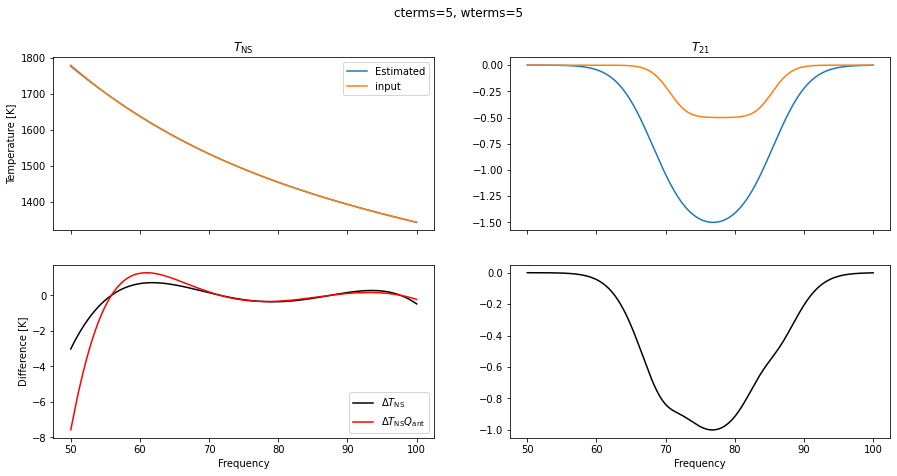

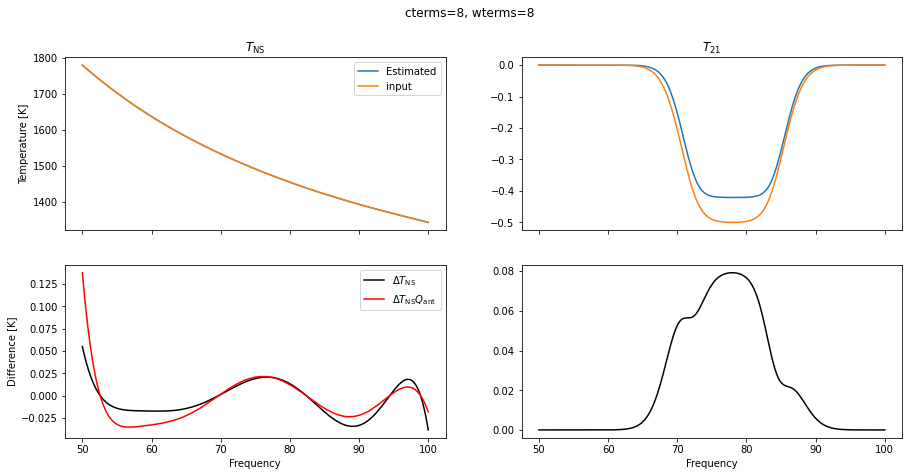

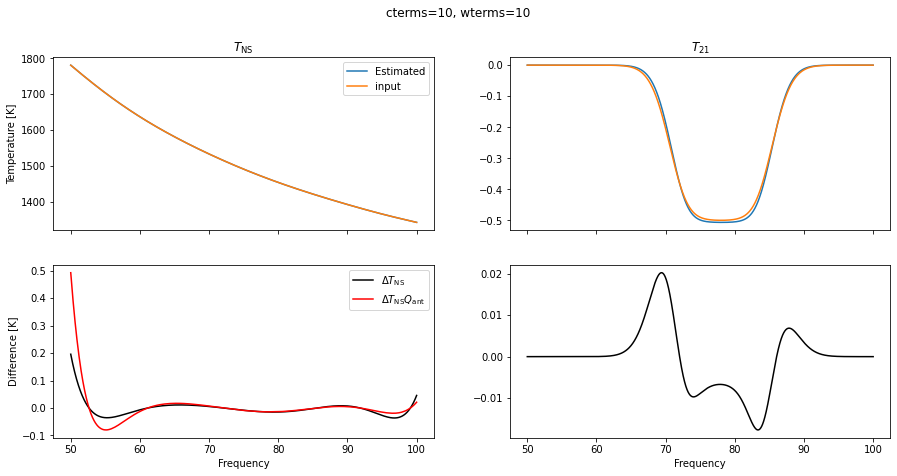

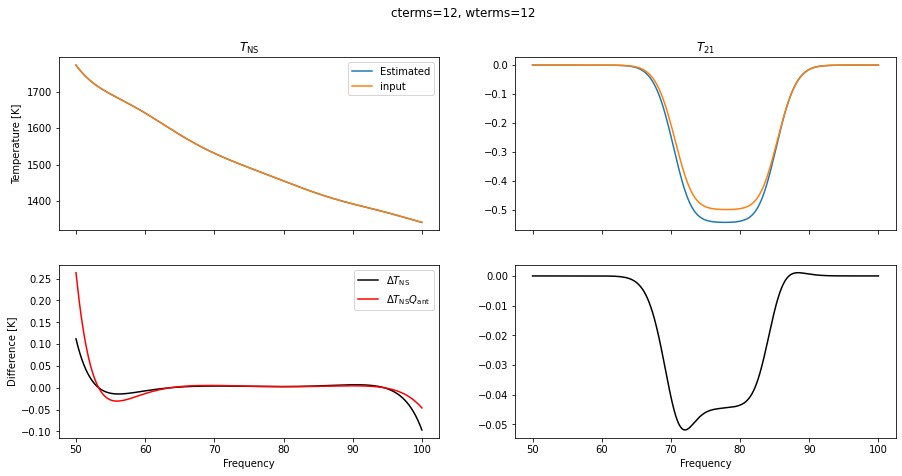

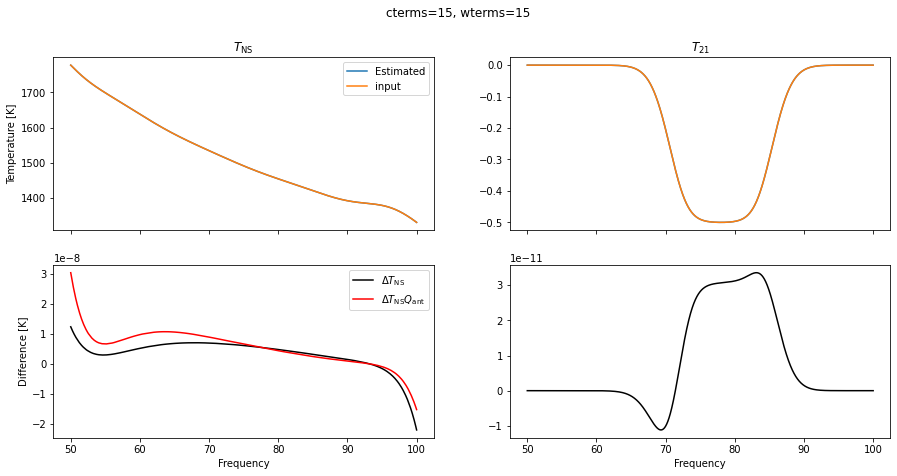

In [17]:
figs = []
for terms in [5, 8, 10, 12, 15]: #, 18, 20, 25, 30, 40, 50]:
    res, lk, c = get_results_with_nterms(terms, terms)
    fig = view_results(lk, res, sim_tns=False, calobs=c)
    fig.suptitle(f"cterms={terms}, wterms={terms}")
    figs.append(fig)

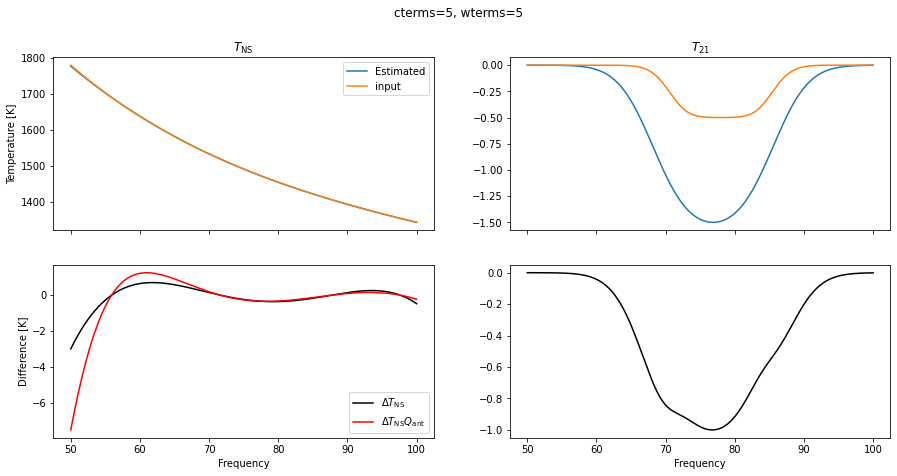

In [34]:
figs[0]

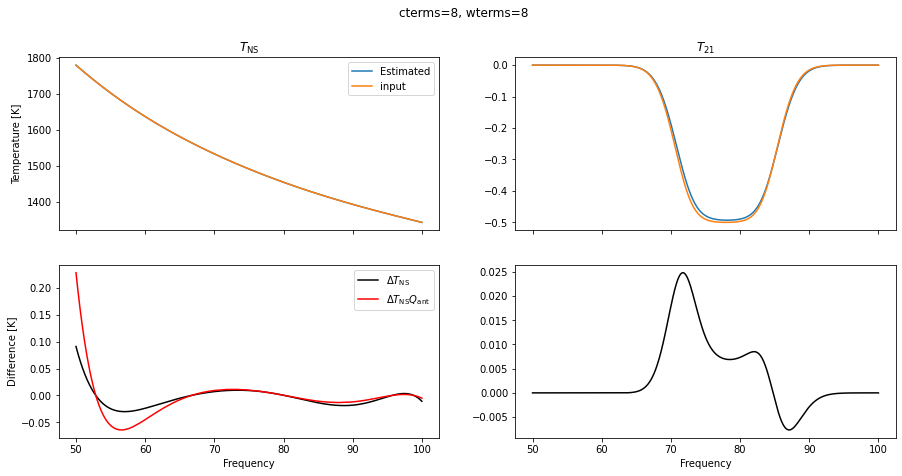

In [35]:
figs[1]

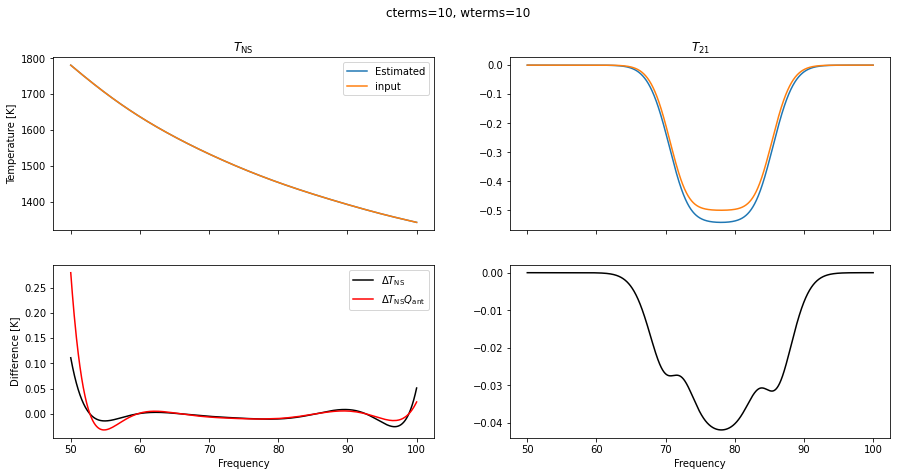

In [36]:
figs[2]

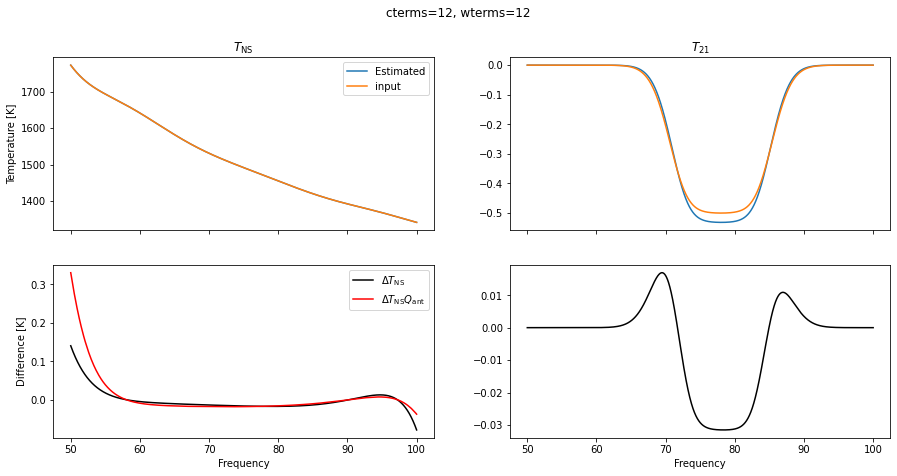

In [37]:
figs[3]

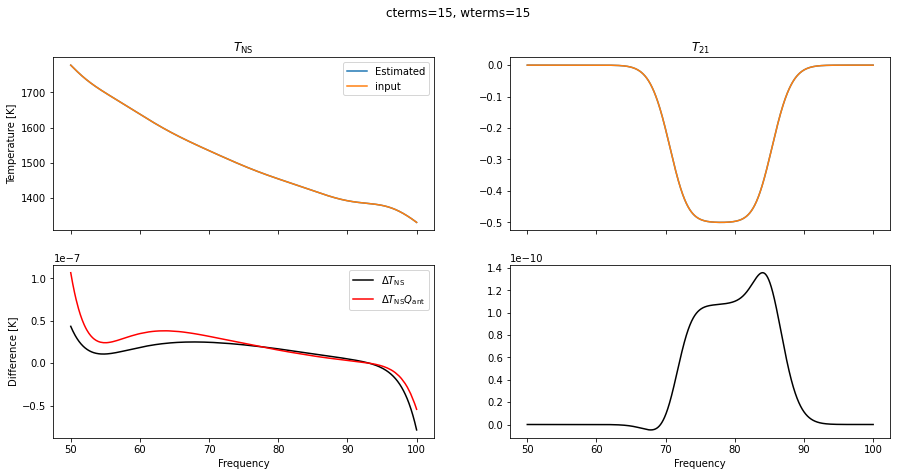

In [38]:
figs[4]

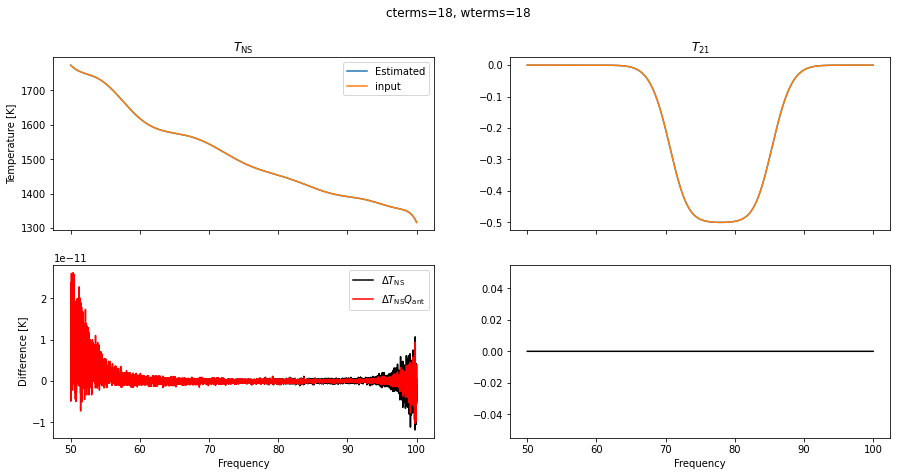

In [39]:
figs[5]

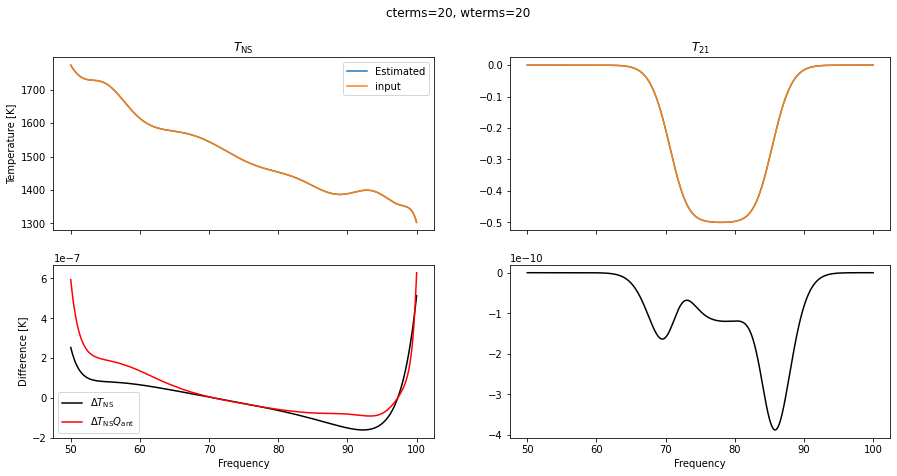

In [40]:
figs[6]

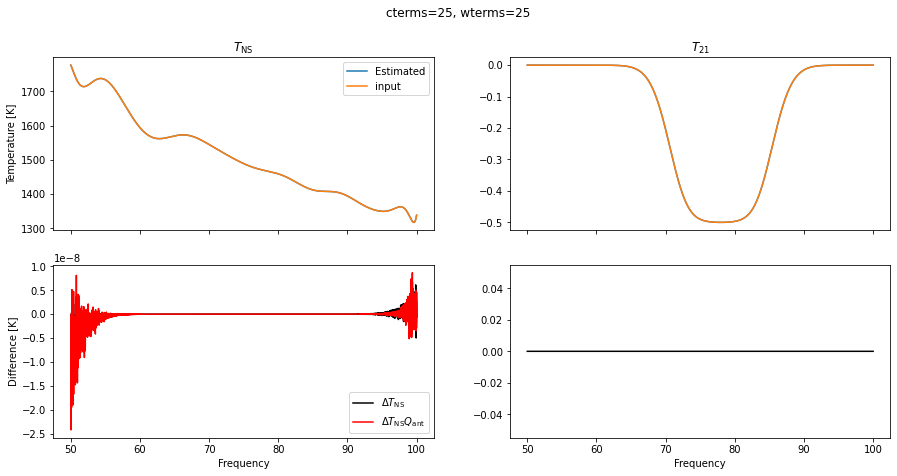

In [41]:
figs[7]

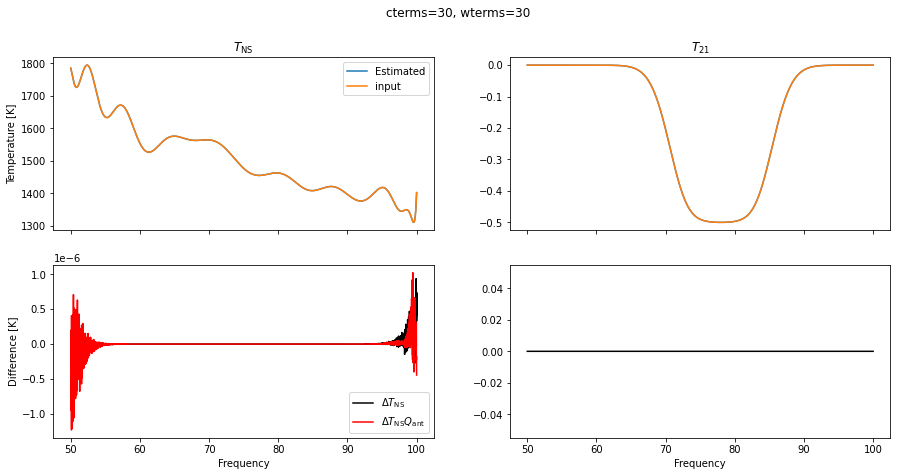

In [42]:
figs[8]

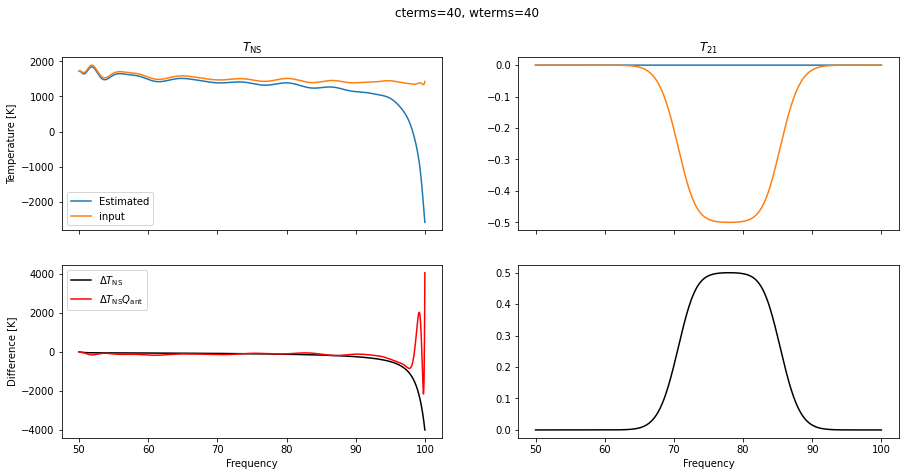

In [43]:
figs[9]

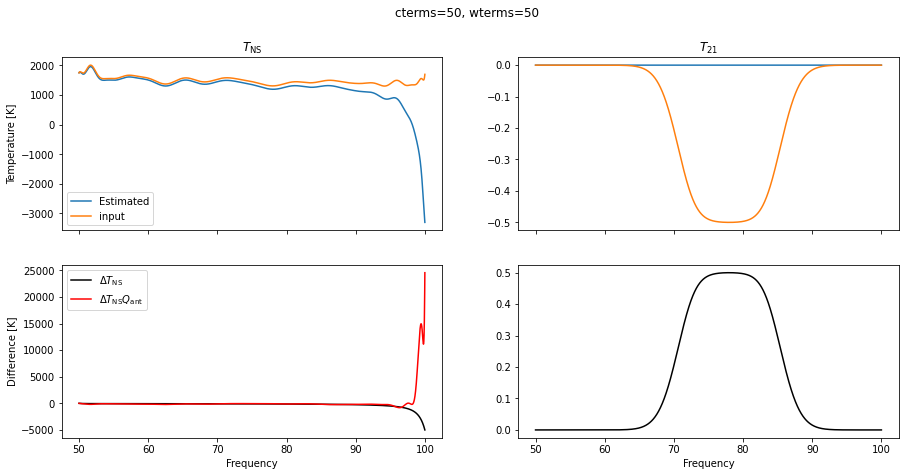

In [44]:
figs[10]

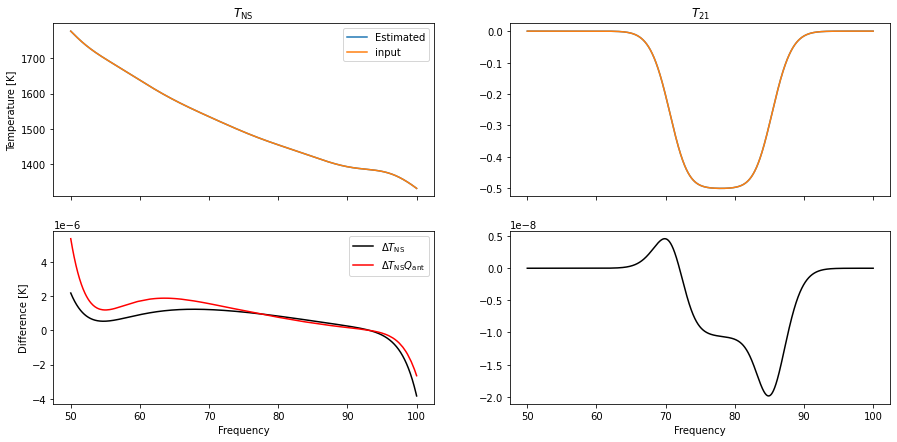

In [45]:
view_results(data_lk_realhigh, res_data, sim_tns=False, calobs=calobs_high)

Well, this certainly seemed to do the trick! It's hard to know if the main thing going wrong was 

1. The difference between the true calibration and the assumed traditional calibration
2. The difference between the traditional calibration and the ML calibration

Both of these seemed to have improved with more terms.

### With Fewer Data Frequencies

The last test here is to make sure that when using a smoothed set of frequencies for the data, we still get a good answer.

In [27]:
calobs.freq.n/3

2731.0

In [13]:
res_data, data_lk_realhigh, calobs_high = get_results_with_nterms(15, 15, 32)

/data4/smurray/Projects/radio/EOR/Edges/edges_estimate/src/edges_estimate/likelihoods.py:414: RuntimeWarning: invalid value encountered in log
  logdetCinv = np.log(np.linalg.det((basis / var).dot(basis.T)))


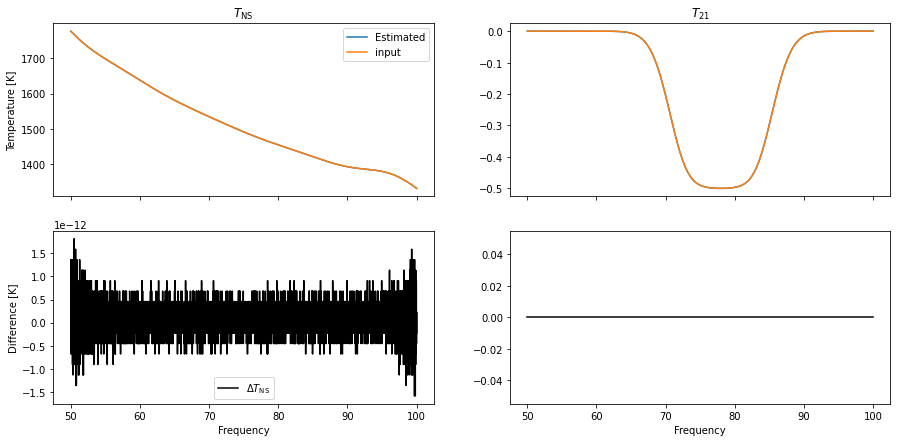

In [31]:
view_results(data_lk_realhigh, res_data, sim_tns=False, calobs=calobs_high, smooth=32);